# Lockdown  for Classification: Female Non Smoker Lung Carcinoma

## Import all necessary libraries

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost import plot_tree

from sklearn.metrics import r2_score, classification_report, confusion_matrix,           \
                            roc_curve, roc_auc_score, plot_confusion_matrix, f1_score,   \
                            balanced_accuracy_score, accuracy_score, mean_squared_error, \
                            log_loss
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier,    \
                                 Lasso, lasso_path
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper

import scipy
from scipy import stats

import os
import sys
import shutil
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import itertools

import time
import tqdm
import copy

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

import PIL
import joblib
import json

# import mysgd

## Datasets and DataLoaders

In [2]:
# Load data
def load_data(fname):
    """
    input (str or path): name of the folder with the data.
    This function reads the data, transforms it to tensors, and makes it
    global.
    """
    global xtrain, xvalid, xtest, xtrain_valid, ytrain, yvalid, ytest, ytrain_valid
# 
    df = pd.read_csv(os.path.join(fname, 'xtrain.csv'), index_col=False, header=None)
    xtrain = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'xvalid.csv'), index_col=False, header=None)
    xvalid = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'xtest.csv'), index_col=False, header=None)
    xtest = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'xtrain_valid.csv'), index_col=False, header=None)
    xtrain_valid = torch.tensor(df.values).float()
# 
    df = pd.read_csv(os.path.join(fname, 'ytrain.csv'), index_col=False, header=None)
    ytrain = torch.tensor(df.values).long()
    df = pd.read_csv(os.path.join(fname, 'yvalid.csv'), index_col=False, header=None)
    yvalid = torch.tensor(df.values).long()
    df = pd.read_csv(os.path.join(fname, 'ytest.csv'), index_col=False, header=None)
    ytest = torch.tensor(df.values).long()
    df = pd.read_csv(os.path.join(fname, 'ytrain_valid.csv'), index_col=False, header=None)
    ytrain_valid = torch.tensor(df.values).long()


In [3]:
# Transform DataFrame to Tensor
def df_to_tensor():
    """
    This function transforms DataFrames to tensors and makes them global.
    """
    global xtrain, xvalid, xtest, ytrain, yvalid, ytest
# 
    xtrain = torch.tensor(xtrain.values).float()
    xvalid = torch.tensor(xvalid.values).float()
    xtest = torch.tensor(xtest.values).float()
# 
    ytrain = torch.tensor(ytrain.values).long()
    yvalid = torch.tensor(yvalid.values).long()
    ytest = torch.tensor(ytest.values).long()

* ### Read and Clean Data

In [4]:
# Read X and y
X = pd.read_csv('dataset_10LungCarcinoma/GDS3837_gene_profile.csv', index_col=0)
dfy = pd.read_csv('dataset_10LungCarcinoma/GDS3837_output.csv', index_col=0)

In [5]:
# Change column names
cols = X.columns.tolist()
for i in range(len(cols)):
    cols[i] = cols[i].lower()
    cols[i] = cols[i].replace('-', '_')
    cols[i] = cols[i].replace('.', '_')
    cols[i] = cols[i].strip()
X.columns = cols
cols_all = X.columns

cols = dfy.columns.tolist()
for i in range(len(cols)):
    cols[i] = cols[i].lower()
    cols[i] = cols[i].replace('-', '_')
    cols[i] = cols[i].replace('.', '_')
    cols[i] = cols[i].strip()
dfy.columns = cols

# Set target
dfy['disease_state'] = dfy['disease_state'].str.replace(' ', '_')
dfy.replace({'disease_state': {"lung_cancer": 1, "control": 0}}, inplace=True)
y = pd.DataFrame(dfy['disease_state'])

In [6]:
# Display data set info
n_features = X.shape[1]
print("- Number of features: {}\n".format(n_features))

print("- Dataset shape: {}\n".format(X.shape))

print("- Missing (X) values: {} points.".format(X.isna().sum().sum()))
print("- Missing (y) values: {} points.\n".format(y.isna().sum().sum()))

print("- Class probabilities:")
print("  label = 1: {}%".format(100*(y.iloc[:,0] == 1).sum()/len(y)))
print("  label = 0: {}%\n".format(100*(y.iloc[:,0] == 0).sum()/len(y)))


- Number of features: 54675

- Dataset shape: (120, 54675)

- Missing (X) values: 0 points.
- Missing (y) values: 0 points.

- Class probabilities:
  label = 1: 50.0%
  label = 0: 50.0%



* ### Split and Save

In [7]:
# # Random seeds for the splits
# seed1 = torch.randint(0, 1000, (500,))
# seed2 = torch.randint(1001, 2000, (500,))
seed1 = pd.read_csv('seed1.csv', header=None).iloc[:,0].tolist()
seed2 = pd.read_csv('seed2.csv', header=None).iloc[:,0].tolist()

In [8]:
# Split data (function)
def split_data(dfX, dfy, seed1=0, seed2=42):
    global xtrain, xvalid, xtest, xtrain_valid, ytrain, yvalid, ytest, ytrain_valid
    xtrain_valid, xtest, ytrain_valid, ytest = train_test_split(dfX, dfy, 
                                                      test_size=0.2, 
                                                      random_state=seed1)
    xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain_valid, ytrain_valid, 
                                                      test_size=0.25, 
                                                      random_state=seed2)

In [10]:
# Set (xtrain, ytrain), (xvalid, yvalid), and (xtest, ytest)
data_folder = 'dataset_10LungCarcinoma'
split_data(X, y)

# Save data on disk
xtrain.to_csv(os.path.join(data_folder, 'xtrain.csv'), index=False, header=False)
xvalid.to_csv(os.path.join(data_folder, 'xvalid.csv'), index=False, header=False)
xtest.to_csv(os.path.join(data_folder, 'xtest.csv'), index=False, header=False)
xtrain_valid.to_csv(os.path.join(data_folder, 'xtrain_valid.csv'), index=False, header=False)
X.to_csv(os.path.join(data_folder, 'X.csv'), index=False, header=False)

ytrain.to_csv(os.path.join(data_folder, 'ytrain.csv'), index=False, header=False)
yvalid.to_csv(os.path.join(data_folder, 'yvalid.csv'), index=False, header=False)
ytest.to_csv(os.path.join(data_folder, 'ytest.csv'), index=False, header=False)
ytrain_valid.to_csv(os.path.join(data_folder, 'ytrain_valid.csv'), index=False, header=False)
y.to_csv(os.path.join(data_folder, 'y.csv'), index=False, header=False)

# 
print("- xtrain size: {}".format(xtrain.shape))
print("- xvalid size: {}".format(xvalid.shape))
print("- xtest size: {}".format(xtest.shape))
print("- xtrain_valid size: {}\n".format(xtrain_valid.shape))

- xtrain size: (72, 54675)
- xvalid size: (24, 54675)
- xtest size: (24, 54675)
- xtrain_valid size: (96, 54675)



* ### Create Datasets and DataLoaders

In [10]:
# Create Dataset class
class MyDataset(Dataset):
    '''
    Input:
        xtensor (torch tensor): data points; dimension [# of points, # of features]
        ytensor (torch tensor): y values; dimension [# of points]
    Output:
        the usual...
    '''
    def __init__(self, xtensor, ytensor):
        self.x = xtensor
        self.y = ytensor
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx], idx

In [11]:
# Instantiate DataLoaders
def make_DataLoaders(batch_size=100000, num_workers = 0):
    """
    This function instantiate and makes global DataLoaders for training, 
    validation, and testing datasets. 
    """
# .create datasets
    train_dataset = MyDataset(xtrain, ytrain)
    valid_dataset = MyDataset(xvalid, yvalid)
    test_dataset = MyDataset(xtest, ytest)
    
# .make dataloaders global variables
    global train_dataloader, valid_dataloader, test_dataloader
    train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = True, 
                                                   num_workers=num_workers)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = True, 
                                                   num_workers=num_workers)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = False, 
                                                   num_workers=num_workers)
    print('- train minibatches =', len(train_dataloader))
    print('- valid minibatches =', len(valid_dataloader))
    print('- test minibatches =', len(test_dataloader))

In [13]:
# Select type of processor to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cuda'):
    print("-Type of precessor to be used: 'gpu'")
    !nvidia-smi
else:
    print("-Type of precessor to be used: 'cpu'")
    
# Choose device
# torch.cuda.set_device(6)

-Type of precessor to be used: 'cpu'


## Optimizer and Loss Function

In [14]:
# Set up SGD optimizer with a constant learning rate
def setup_SGD(model, lr):
    """
    Args:
        model (nn.Module class): model previously instantiated
        lr (float): learning rate
    Returns:
        instantiated optimizer
    """
    return optim.SGD(model.parameters(), lr=lr, momentum=0,  weight_decay=0.0)

In [15]:
# Set up Adam optimizer with a constant learning rate
def setup_ADAM(model, lr):
    """
    Args:
        model (nn.Module class): model previously instantiated
        lr (float): learning rate
    Returns:
        instantiated optimizer
    """
    return optim.Adam(model.parameters(), lr=lr,  weight_decay=0.0)

In [16]:
# Type of Loss Function
loss_type = nn.CrossEntropyLoss(reduction='mean')

## Train model

In [17]:
# PyTorch sign function
def sgn(x):
    return torch.sign(x)

In [18]:
# Number of correct predictions in a multi-class classification problem
def accuracy_multiclass(output, target):
    """
    Args:
        output (torch tensor): 2D tensor of shape (batch_size, n_classes) resulting 
                               of running the model.
        target (torch tensor): 1D tensor with the corresponding class for each image.
    Returns:
        correct (int): number of correct predictions.
    """
    correct = 0
    prob_softmax = nn.Softmax(dim=1)
    _, predictions = torch.max(prob_softmax(output), dim=1)
    correct = (predictions == target).sum(dim=0)
    return correct

In [19]:
# Compute accuracy
def dataset_accuracy(data_loader, model, device):
    """
    Args:
        data_loader: torch DataLoader.
        model:       torch model previously trained.
        device: 'gpu' or 'cpu'.
    Returns:
        Accuracy for the given data set.
    """
# Initialize some local variables
    correct_total = 0
    n_points = 0
    
# Put model in evaluation mode
    model.eval()

# Loop over mini batches (no gradients need to be computed)
    with torch.no_grad():
        for i, (xx, yy, _) in enumerate(data_loader, start=1):
            batch_size = len(yy)
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)
        
# .compute accuracy (target size must be [batch_size])
            correct = accuracy_multiclass(yy_pred, yy.view(-1))
            correct_total += correct
        
# .number of points used after the ith mini-batch
            n_points += batch_size
#
    return correct_total.item()/n_points

In [20]:
# Train model (classification)
def train_model(lr, features, layer_sizes, lock_flag=False, epochs=3000, 
                early_stop=300, fname='model'):
    """
    """
# Set seed of random generators (for reproducibility purposes)
#     torch.manual_seed(42)

# Instantiate Model and Optimizer
    model = MyNet(features, layer_sizes)
    if lock_flag == True:
        model.load_state_dict(torch.load(model_forward_name))
    model = model.to(device)
    optimizer = setup_SGD(model, lr)

# LOCKDOWN SECTION 1:
    if lock_flag == True:
        n_iterations = epochs*len(train_dataloader)
        layers = get_lockdown_layers(model)
        t0 = []
        t0_initial = []
        sign_w0 = []
        l = 0
        for layer in layers:
            ww = layer.weight.detach()
            t0.append(abs(ww).sum())
            sign_w0.append(torch.sign(ww))
            t0_initial.append(t0[l])
            l += 1
    
# DataFrames to store train/valid loss function
    train_loss = pd.DataFrame(columns=['iteration', 'loss'])
    valid_loss = pd.DataFrame(columns=['iteration', 'loss'])

# Initialize some local variables...
    iteration = 0
    best_iter = 0
    best_loss = 1e30
    stop_flag = 0

# Loop Over Number of Epochs
    iterator = tqdm.notebook.tqdm(range(1, epochs + 1), desc='Epochs loop')
    for n_epoch in iterator:
# 
# .Loop Over Mini-batches
        for ibatch, (xx, yy, _) in enumerate(train_dataloader, start=1):
#
# ..Compute Validation Loss
            model_dict = copy.deepcopy(model.state_dict())
            epoch_loss = valid_epoch(valid_dataloader, model, loss_type, device)
            valid_loss = valid_loss.append({'iteration': iteration + 1, 
                                            'loss': epoch_loss}, 
                                            ignore_index=True)
# ..Train Mini-batch:
            model.train()
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)

# ..Compute Train Loss
            loss = loss_type(yy_pred, yy.view(-1))
            train_loss = train_loss.append({'iteration': iteration + 1,
                                            'loss': loss.item()}, 
                                           ignore_index=True)
# ..Backward Propagation
            optimizer.zero_grad()
            loss.backward()

# ..LOCKDOWN SECTION 2:
            if lock_flag == True:
                l = 0
                for layer in layers:
# ...weights and gradients (2D)
                    w2d = layer.weight.detach()
                    g2d = layer.weight.grad.detach()
                    w_shape = g2d.size()

# ...flattens weights and compute P(W)
                    w1d = torch.flatten(w2d)
                    Pw = abs(w1d).sum()

# ...find g=-grads, 'gamma', and sort gamma (in descending order)
                    p1d = 1.0
                    g1d = -torch.flatten(g2d)
                    gamma = abs(g1d)/(p1d + 1e-10)
                    _, indx1d = torch.sort(gamma, descending=True)

# ...Modify Gradients Accordingly:
                    grmin = torch.zeros(w_shape).fill_(1e-1).to(device)
                    layer.weight.grad = torch.sign(g2d)*torch.max(abs(g2d), grmin)
                    gr1d = torch.flatten(layer.weight.grad.detach())
                    pjsj = lr*abs(gr1d[indx1d])

# ...sign(g) != sign(w) elements
                    mask_ds = (sgn(g1d[indx1d]) != sgn(w1d[indx1d])) & (w1d[indx1d] != 0.0)
                    DS_sum = pjsj[mask_ds].sum()
                    pjsj[mask_ds] = 0.0
                    mask_dsc = ~mask_ds
                    indx1d_dsc = indx1d[mask_dsc]

# ...sum(pjsj), j={1,J-1}
                    left_side = torch.cumsum(pjsj, dim=0) - pjsj
                    pjsj_dsc = torch.zeros(len(g1d)).to(device)
                    pjsj_dsc[:] = pjsj[:]

# ...sum(pjsj) + Penalty, j={J+1,nJ}
                    mask_w0 = (w1d[indx1d] == 0.0)
                    pjsj_dsc[mask_w0] = 0.0
                    right_side = pjsj_dsc.sum() - torch.cumsum(pjsj_dsc, dim=0) + DS_sum - Pw + t0[l]

# ...delta_j and new steps
                    ds = right_side - left_side
                    mask_w0 = (~mask_w0).float()
                    pjsj_new = -mask_w0**(1-sgn(ds))*sgn(g1d[indx1d])*sgn(ds)*torch.min(pjsj, abs(ds))

# ...modify gradients
                    indx2d = np.unravel_index(indx1d_dsc.cpu(), shape=w_shape)
                    layer.weight.grad[indx2d] = pjsj_new[mask_dsc]/lr
                    l = l + 1

# ..Update Weights 
            optimizer.step()

# ..LOCKDOWN SECTION 3:
            if lock_flag == True:
# ...Set Weights That Change Signs to Zero
                l = 0
                for layer in layers:
                    ww = layer.weight.detach()
                    sign_w = sgn(ww)
                    mask0 = ((sign_w != sign_w0[l]) & (sign_w0[l] != 0.0))
                    with torch.no_grad():
                        layer.weight[mask0] = 0.0
                    sign_w0[l] = sign_w
                    
# ...Tighten Constraint
                    if iteration%step == 0:
                        t0[l] = (1.0 - iteration/n_iterations)*t0_initial[l]
                    l = l + 1
                    

# ..Early Stop
            batch_loss = valid_loss.iloc[iteration, 1]
            if batch_loss < best_loss:
                torch.save(model_dict, fname+"_best.pth")
                best_loss = batch_loss
                best_iter = iteration
            else:
                if iteration - best_iter >= early_stop:
                    stop_flag = 1
                    break
# 
            iteration += 1
# 
        if stop_flag == 1:
            break
# 
    if lock_flag == False:
        torch.save(model_dict, fname+"_last.pth")
    print("Summary:")
    print("-learning rate = {:.5f}".format(lr))
    if stop_flag == 1:
        print('-path 1 has early stopped:')
        print(' {:d} iterations with no improvement in train loss.'.format(early_stop))
    print("-Model saved after iteration {:d}.".format(best_iter + 1))
    print("-Train.  Loss={:.7f}".format(train_loss.iloc[best_iter, 1]))
    print("-Valid.  Loss={:.7f}".format(valid_loss.iloc[best_iter, 1]))
# 
    return train_loss, valid_loss

In [21]:
# Evaluate one epoch (classification)
def valid_epoch(data_loader, model, loss_type, device):
    """
    Args:
        data_loader: torch DataLoader.
        model:       torch model previously trained.
        device: 'gpu' or 'cpu'.
    Returns:
        Values of Loss Function after one epoch.
    """
# Initialize some local variables
    loss_fun = 0.
    n_points = 0
    
# Put model in evaluation mode
    model.eval()

# Loop over mini batches (no gradients need to be computed)
    with torch.no_grad():
        for i, (xx, yy, _) in enumerate(data_loader, start=1):
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)
        
# .compute loss function
            batch_size = len(yy)
            loss = loss_type(yy_pred, yy.view(-1))
            loss_fun += batch_size*loss.item()
        
# .number of points used after the ith mini-batch
            n_points += batch_size
#
    return loss_fun/n_points

## Results:

* ### Lasso

In [9]:
# Load data
load_data('dataset_10LungCarcinoma')

# transform tensors to NumPy arrays
xtrain = xtrain.numpy()
xvalid = xvalid.numpy()
xtest = xtest.numpy()

ytrain = ytrain.numpy()
yvalid = yvalid.numpy()
ytest = ytest.numpy()

In [10]:
# Normalize data sets
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xvalid = scaler.transform(xvalid)
xtest  = scaler.transform(xtest)

In [11]:
# Grid search space
grid_C = np.geomspace(1e-2, 1e3, num=500)
df_grid_loss = pd.DataFrame(columns = ['C', 'valid_loss', 'valid_accu'], 
                            index=range(len(grid_C)))

params = {'penalty': 'l1', 
          'solver': 'liblinear',
          'max_iter': 10000,
          'random_state': 42,
          'warm_start': True}

In [12]:
# Perform grid search
iterator = tqdm.notebook.tqdm(range(1, len(grid_C) + 1), desc='C-grid loop')
for n in iterator:
    irow = n-1
    params['C'] = grid_C[irow]
    log_clf = LogisticRegression(**params).fit(xtrain, ytrain.ravel())
    
    ypred = log_clf.predict_proba(xvalid)
    val_loss = log_loss(yvalid, ypred)
    val_accu = log_clf.score(xvalid, yvalid.ravel())
    
    df_grid_loss.iloc[irow,:] = [params['C'], val_loss, val_accu]
    print("C={:.5f} | valid_logloss={:.5f},  valid_accu={:.5f}".format(params['C'], 
                                                                       val_loss, 
                                                                       val_accu))
df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_loss.csv'), index=None)

C-grid loop:   0%|          | 0/500 [00:00<?, ?it/s]

C=0.01000 | valid_logloss=0.69315,  valid_accu=0.45833
C=0.01023 | valid_logloss=0.69315,  valid_accu=0.45833
C=0.01047 | valid_logloss=0.69315,  valid_accu=0.45833
C=0.01072 | valid_logloss=0.69315,  valid_accu=0.45833
C=0.01097 | valid_logloss=0.69315,  valid_accu=0.45833
C=0.01122 | valid_logloss=0.69315,  valid_accu=0.45833
C=0.01148 | valid_logloss=0.69315,  valid_accu=0.45833
C=0.01175 | valid_logloss=0.69315,  valid_accu=0.45833
C=0.01203 | valid_logloss=0.69315,  valid_accu=0.45833
C=0.01231 | valid_logloss=0.69315,  valid_accu=0.45833
C=0.01260 | valid_logloss=0.69315,  valid_accu=0.45833
C=0.01289 | valid_logloss=0.69315,  valid_accu=0.45833
C=0.01319 | valid_logloss=0.69315,  valid_accu=0.45833
C=0.01350 | valid_logloss=0.69315,  valid_accu=0.45833
C=0.01381 | valid_logloss=0.69315,  valid_accu=0.45833
C=0.01414 | valid_logloss=0.69315,  valid_accu=0.45833
C=0.01447 | valid_logloss=0.69315,  valid_accu=0.45833
C=0.01480 | valid_logloss=0.69315,  valid_accu=0.45833
C=0.01515 

C=0.31116 | valid_logloss=0.10381,  valid_accu=1.00000
C=0.31842 | valid_logloss=0.11428,  valid_accu=0.95833
C=0.32586 | valid_logloss=0.10491,  valid_accu=1.00000
C=0.33346 | valid_logloss=0.09997,  valid_accu=1.00000
C=0.34124 | valid_logloss=0.10610,  valid_accu=0.95833
C=0.34921 | valid_logloss=0.10689,  valid_accu=1.00000
C=0.35736 | valid_logloss=0.09352,  valid_accu=1.00000
C=0.36570 | valid_logloss=0.10538,  valid_accu=0.95833
C=0.37424 | valid_logloss=0.10071,  valid_accu=1.00000
C=0.38297 | valid_logloss=0.09629,  valid_accu=1.00000
C=0.39191 | valid_logloss=0.09766,  valid_accu=1.00000
C=0.40106 | valid_logloss=0.09696,  valid_accu=0.95833
C=0.41042 | valid_logloss=0.08951,  valid_accu=1.00000
C=0.42000 | valid_logloss=0.09677,  valid_accu=0.95833
C=0.42980 | valid_logloss=0.10380,  valid_accu=0.95833
C=0.43983 | valid_logloss=0.09254,  valid_accu=1.00000
C=0.45010 | valid_logloss=0.08444,  valid_accu=1.00000
C=0.46060 | valid_logloss=0.08515,  valid_accu=1.00000
C=0.47135 

C=9.68215 | valid_logloss=0.01293,  valid_accu=1.00000
C=9.90814 | valid_logloss=0.01521,  valid_accu=1.00000
C=10.13939 | valid_logloss=0.01520,  valid_accu=1.00000
C=10.37605 | valid_logloss=0.02353,  valid_accu=1.00000
C=10.61823 | valid_logloss=0.01089,  valid_accu=1.00000
C=10.86606 | valid_logloss=0.01479,  valid_accu=1.00000
C=11.11968 | valid_logloss=0.02042,  valid_accu=1.00000
C=11.37921 | valid_logloss=0.01165,  valid_accu=1.00000
C=11.64481 | valid_logloss=0.01910,  valid_accu=1.00000
C=11.91660 | valid_logloss=0.02178,  valid_accu=1.00000
C=12.19473 | valid_logloss=0.01321,  valid_accu=1.00000
C=12.47936 | valid_logloss=0.01506,  valid_accu=1.00000
C=12.77063 | valid_logloss=0.01979,  valid_accu=1.00000
C=13.06870 | valid_logloss=0.01299,  valid_accu=1.00000
C=13.37373 | valid_logloss=0.01276,  valid_accu=1.00000
C=13.68587 | valid_logloss=0.01428,  valid_accu=1.00000
C=14.00531 | valid_logloss=0.01939,  valid_accu=1.00000
C=14.33219 | valid_logloss=0.01985,  valid_accu=1.

C=281.12392 | valid_logloss=0.00782,  valid_accu=1.00000
C=287.68541 | valid_logloss=0.00863,  valid_accu=1.00000
C=294.40005 | valid_logloss=0.00858,  valid_accu=1.00000
C=301.27141 | valid_logloss=0.01020,  valid_accu=1.00000
C=308.30315 | valid_logloss=0.00793,  valid_accu=1.00000
C=315.49901 | valid_logloss=0.01312,  valid_accu=1.00000
C=322.86282 | valid_logloss=0.02169,  valid_accu=1.00000
C=330.39851 | valid_logloss=0.00668,  valid_accu=1.00000
C=338.11008 | valid_logloss=0.01278,  valid_accu=1.00000
C=346.00164 | valid_logloss=0.00554,  valid_accu=1.00000
C=354.07739 | valid_logloss=0.01152,  valid_accu=1.00000
C=362.34163 | valid_logloss=0.00526,  valid_accu=1.00000
C=370.79876 | valid_logloss=0.01194,  valid_accu=1.00000
C=379.45328 | valid_logloss=0.01297,  valid_accu=1.00000
C=388.30980 | valid_logloss=0.00566,  valid_accu=1.00000
C=397.37304 | valid_logloss=0.00346,  valid_accu=1.00000
C=406.64781 | valid_logloss=0.00306,  valid_accu=1.00000
C=416.13906 | valid_logloss=0.0

NameError: name 'data_out' is not defined

In [14]:
# Display grid search results
data_out = 'data_lasso_10LungCarcinoma'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss.csv'))

idx = df_grid_loss.valid_loss.idxmin()
best_C   = df_grid_loss.iloc[idx, 0]
best_loss  = df_grid_loss.iloc[idx, 1]
print("Best parameters:")
print("- Best C = {:.5f}".format(best_C))
print("- Best valid loss = {:.5f}".format(best_loss))

Best parameters:
- Best C = 645.37154
- Best valid loss = 0.00119


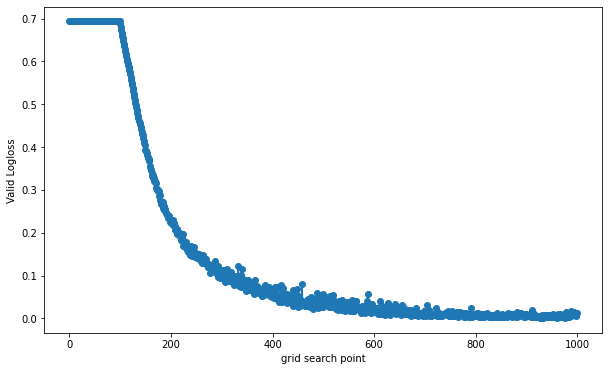

In [15]:
# Plot Loss vs point in grid search
data_out = 'data_lasso_10LungCarcinoma'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss.csv'))
fig, axes = plt.subplots(figsize=(10,6))
axes.scatter(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.plot(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.set_xlabel("grid search point")
axes.set_ylabel("Valid Logloss")
plt.show()

In [16]:
# Train with best hyperparameters
params['C'] = best_C
log_clf = LogisticRegression(**params).fit(xtrain, ytrain.ravel())

In [17]:
# Save model and model's best params
data_out = 'data_lasso_10LungCarcinoma'
joblib.dump(log_clf, os.path.join(data_out, 'lasso_model_val.pkl'))
print("model saved at: '{}'".format(os.path.join(data_out, 'lasso_model_val.pkl')))

best_params = {}
best_params['C'] = best_C
with open(os.path.join(data_out, 'lasso_best_params.json'), 'w') as f:
    json.dump(best_params, f)
print("best params saved at: '{}'".format(os.path.join(data_out, 'lasso_best_params.json')))

model saved at: 'data_lasso_10LungCarcinoma/lasso_model_val.pkl'
best params saved at: 'data_lasso_10LungCarcinoma/lasso_best_params.json'


In [18]:
# Find MSE, R2, Accuracy, etc...
data_out = 'data_lasso_10LungCarcinoma'
model = joblib.load(os.path.join(data_out, 'lasso_model_val.pkl'))

df_results = pd.DataFrame(index=['train', 'valid', 'test'], 
                           columns=['accuracy', 'roc_auc'])

ypred = model.predict(xtrain)
df_results.loc['train', 'accuracy'] = accuracy_score(ytrain, ypred)
df_results.loc['train', 'roc_auc']  = roc_auc_score(ytrain, ypred)

ypred = model.predict(xvalid)
df_results.loc['valid', 'accuracy'] = accuracy_score(yvalid, ypred)
df_results.loc['valid', 'roc_auc']  = roc_auc_score(yvalid, ypred)

ypred = model.predict(xtest)
df_results.loc['test', 'accuracy'] = accuracy_score(ytest, ypred)
df_results.loc['test', 'roc_auc']  = roc_auc_score(ytest, ypred)

# Save data
df_results.to_csv(os.path.join(data_out, 'results_target_val.csv'), index=True)
print("model results saved at: '{}'".format(os.path.join(data_out, 'results_target_val.csv')))
df_results.head()

model results saved at: 'data_lasso_10LungCarcinoma/results_target_val.csv'


,accuracy,roc_auc
train,1,1
valid,1,1
test,0.958333,0.95


In [26]:
# Find Accuracy +/- STD
data_out = 'data_lasso_10LungCarcinoma'
df_results = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 'train_roc', 'valid_roc', 'test_roc'])

model = joblib.load(os.path.join(data_out, 'lasso_model_val.pkl'))

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
X = pd.read_csv('dataset_10LungCarcinoma/X.csv', header=None)
y = pd.read_csv('dataset_10LungCarcinoma/y.csv', header=None)
for n in iterator:
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])
    
# .normalize data sets
    scaler = StandardScaler()
    scaler.fit(xtrain)
    xtrain = scaler.transform(xtrain)
    xvalid = scaler.transform(xvalid)
    xtest  = scaler.transform(xtest)
    
# .train model
    ytrain = ytrain.values.ravel()
    yvalid = yvalid.values.ravel()
    ytest  = ytest.values.ravel()
    model.fit(xtrain, ytrain)
    
# .compute/save accuracy
    ypred = model.predict(xtrain)
    df_results.loc[n, 'train_acc'] = accuracy_score(ytrain, ypred)
    df_results.loc[n, 'train_roc']  = roc_auc_score(ytrain, ypred)

    ypred = model.predict(xvalid)
    df_results.loc[n, 'valid_acc'] = accuracy_score(yvalid, ypred)
    df_results.loc[n, 'valid_roc']  = roc_auc_score(yvalid, ypred)

    ypred = model.predict(xtest)
    df_results.loc[n, 'test_acc'] = accuracy_score(ytest, ypred)
    df_results.loc[n, 'test_roc']  = roc_auc_score(ytest, ypred)

    joblib.dump(model, os.path.join(data_out, 'lasso_model_val_'+str(n)+'.pkl'))
    df_results.to_csv(os.path.join(data_out, 'accuracy10_lasso_val.csv'), index=None)

Partitions loop:   0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
# Display results
data_out = 'data_lasso_10LungCarcinoma'
accuracy_lasso = pd.read_csv(os.path.join(data_out, 'accuracy10_lasso_val.csv'))
print("Train accuracy = {:.3f} +/- {:.3f}".format(accuracy_lasso['train_acc'].mean(), 
                                                  accuracy_lasso['train_acc'].std()))
print("Valid accuracy = {:.3f} +/- {:.3f}".format(accuracy_lasso['valid_acc'].mean(), 
                                                  accuracy_lasso['valid_acc'].std()))
print("Test accuracy = {:.3f} +/- {:.3f}".format(accuracy_lasso['test_acc'].mean(), 
                                                 accuracy_lasso['test_acc'].std()))

Train accuracy = 1.000 +/- 0.000
Valid accuracy = 0.950 +/- 0.041
Test accuracy = 0.947 +/- 0.041


* ### Gradient Boosting

In [192]:
# Load data
load_data('dataset_10LungCarcinoma')

# transform tensors to NumPy arrays
xtrain = xtrain.numpy()
xvalid = xvalid.numpy()
xtest = xtest.numpy()

ytrain = ytrain.numpy()
yvalid = yvalid.numpy()
ytest = ytest.numpy()

In [193]:
# Normalize data sets
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xvalid = scaler.transform(xvalid)
xtest  = scaler.transform(xtest)

In [194]:
# Build DMatrices
dtrain = xgb.DMatrix(data=xtrain, label=ytrain, nthread=10, feature_names=cols_all)
dvalid = xgb.DMatrix(data=xvalid, label=yvalid, nthread=10, feature_names=cols_all)
dtest  = xgb.DMatrix(data=xtest,  label=ytest,  nthread=10, feature_names=cols_all)

valid_list = [(dtrain, 'train'), (dvalid, 'valid')]

In [195]:
# Grid search space
grid_eta   = np.linspace(0.01, 0.99, num=100)
grid_depth = [1, 2, 3, 4, 5]
grid_param = [(eta, max_depth) for eta in grid_eta
                               for max_depth in grid_depth]

param = [('eta', 0.01), 
         ('max_depth', 2), 
         ('objective', 'binary:logistic'), 
         ('nthread', 16),
         ('eval_metric', 'logloss')
]

In [40]:
# Perform grid search
df_grid_loss = pd.DataFrame(columns = ['eta', 'max_depth', 'valid_loss'], 
                            index = range(len(grid_param)))
i = 0
for eta, max_depth in grid_param:
    param[0] = ('eta', eta)
    param[1] = ('max_depth', max_depth)
    
    xgb_clf = xgb.train(param, dtrain, 
                        num_boost_round = 5000, 
                        evals = valid_list, 
                        early_stopping_rounds = 10, 
                        verbose_eval = False)
    
    print("eta={:.3f}, max_depth={} | valid_logloss={:.5f} (iters={})".format(eta, 
                                                                              max_depth, 
                                                                              xgb_clf.best_score, 
                                                                              xgb_clf.best_iteration))
    df_grid_loss.iloc[i,:] = [eta, max_depth, xgb_clf.best_score]
    i += 1

eta=0.010, max_depth=1 | valid_logloss=0.06549 (iters=540)
eta=0.010, max_depth=2 | valid_logloss=0.05970 (iters=497)
eta=0.010, max_depth=3 | valid_logloss=0.05970 (iters=497)
eta=0.010, max_depth=4 | valid_logloss=0.05970 (iters=497)
eta=0.010, max_depth=5 | valid_logloss=0.05970 (iters=497)
eta=0.020, max_depth=1 | valid_logloss=0.06395 (iters=271)
eta=0.020, max_depth=2 | valid_logloss=0.06224 (iters=249)
eta=0.020, max_depth=3 | valid_logloss=0.06224 (iters=249)
eta=0.020, max_depth=4 | valid_logloss=0.06224 (iters=249)
eta=0.020, max_depth=5 | valid_logloss=0.06224 (iters=249)
eta=0.030, max_depth=1 | valid_logloss=0.06352 (iters=180)
eta=0.030, max_depth=2 | valid_logloss=0.06093 (iters=166)
eta=0.030, max_depth=3 | valid_logloss=0.06093 (iters=166)
eta=0.030, max_depth=4 | valid_logloss=0.06093 (iters=166)
eta=0.030, max_depth=5 | valid_logloss=0.06093 (iters=166)
eta=0.040, max_depth=1 | valid_logloss=0.06516 (iters=135)
eta=0.040, max_depth=2 | valid_logloss=0.05765 (iters=12

eta=0.287, max_depth=2 | valid_logloss=0.05924 (iters=16)
eta=0.287, max_depth=3 | valid_logloss=0.05924 (iters=16)
eta=0.287, max_depth=4 | valid_logloss=0.05924 (iters=16)
eta=0.287, max_depth=5 | valid_logloss=0.05924 (iters=16)
eta=0.297, max_depth=1 | valid_logloss=0.05928 (iters=16)
eta=0.297, max_depth=2 | valid_logloss=0.06279 (iters=15)
eta=0.297, max_depth=3 | valid_logloss=0.06279 (iters=15)
eta=0.297, max_depth=4 | valid_logloss=0.06279 (iters=15)
eta=0.297, max_depth=5 | valid_logloss=0.06279 (iters=15)
eta=0.307, max_depth=1 | valid_logloss=0.06229 (iters=16)
eta=0.307, max_depth=2 | valid_logloss=0.05412 (iters=29)
eta=0.307, max_depth=3 | valid_logloss=0.05412 (iters=29)
eta=0.307, max_depth=4 | valid_logloss=0.05412 (iters=29)
eta=0.307, max_depth=5 | valid_logloss=0.05412 (iters=29)
eta=0.317, max_depth=1 | valid_logloss=0.05958 (iters=14)
eta=0.317, max_depth=2 | valid_logloss=0.05486 (iters=14)
eta=0.317, max_depth=3 | valid_logloss=0.05486 (iters=14)
eta=0.317, max

eta=0.564, max_depth=5 | valid_logloss=0.06155 (iters=7)
eta=0.574, max_depth=1 | valid_logloss=0.04332 (iters=8)
eta=0.574, max_depth=2 | valid_logloss=0.04920 (iters=7)
eta=0.574, max_depth=3 | valid_logloss=0.04920 (iters=7)
eta=0.574, max_depth=4 | valid_logloss=0.04920 (iters=7)
eta=0.574, max_depth=5 | valid_logloss=0.04920 (iters=7)
eta=0.584, max_depth=1 | valid_logloss=0.04224 (iters=8)
eta=0.584, max_depth=2 | valid_logloss=0.05439 (iters=7)
eta=0.584, max_depth=3 | valid_logloss=0.05439 (iters=7)
eta=0.584, max_depth=4 | valid_logloss=0.05439 (iters=7)
eta=0.584, max_depth=5 | valid_logloss=0.05439 (iters=7)
eta=0.594, max_depth=1 | valid_logloss=0.04749 (iters=7)
eta=0.594, max_depth=2 | valid_logloss=0.05557 (iters=6)
eta=0.594, max_depth=3 | valid_logloss=0.05557 (iters=6)
eta=0.594, max_depth=4 | valid_logloss=0.05557 (iters=6)
eta=0.594, max_depth=5 | valid_logloss=0.05557 (iters=6)
eta=0.604, max_depth=1 | valid_logloss=0.04828 (iters=7)
eta=0.604, max_depth=2 | valid_

eta=0.851, max_depth=4 | valid_logloss=0.04027 (iters=4)
eta=0.851, max_depth=5 | valid_logloss=0.04027 (iters=4)
eta=0.861, max_depth=1 | valid_logloss=0.05317 (iters=3)
eta=0.861, max_depth=2 | valid_logloss=0.03969 (iters=4)
eta=0.861, max_depth=3 | valid_logloss=0.03969 (iters=4)
eta=0.861, max_depth=4 | valid_logloss=0.03969 (iters=4)
eta=0.861, max_depth=5 | valid_logloss=0.03969 (iters=4)
eta=0.871, max_depth=1 | valid_logloss=0.05219 (iters=3)
eta=0.871, max_depth=2 | valid_logloss=0.05970 (iters=3)
eta=0.871, max_depth=3 | valid_logloss=0.05970 (iters=3)
eta=0.871, max_depth=4 | valid_logloss=0.05970 (iters=3)
eta=0.871, max_depth=5 | valid_logloss=0.05970 (iters=3)
eta=0.881, max_depth=1 | valid_logloss=0.05124 (iters=3)
eta=0.881, max_depth=2 | valid_logloss=0.03163 (iters=9)
eta=0.881, max_depth=3 | valid_logloss=0.03163 (iters=9)
eta=0.881, max_depth=4 | valid_logloss=0.03163 (iters=9)
eta=0.881, max_depth=5 | valid_logloss=0.03163 (iters=9)
eta=0.891, max_depth=1 | valid_

In [196]:
# Display grid search results
data_out = 'data_xgb_10LungCarcinoma'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss.csv'))
df_grid_loss["valid_loss"] = df_grid_loss["valid_loss"].astype('float64')
df_grid_loss["eta"] = df_grid_loss["eta"].astype('float64')
df_grid_loss["max_depth"] = df_grid_loss["max_depth"].astype('int')

idx = df_grid_loss.valid_loss.idxmin()
best_eta   = df_grid_loss.iloc[idx, 0]
best_depth = df_grid_loss.iloc[idx, 1]
best_loss  = df_grid_loss.iloc[idx, 2]
print("Best parameters:")
print("- Best eta = {:.3f}".format(best_eta))
print("- Best max_depth = {}".format(best_depth))
print("- Best valid loss = {}".format(best_loss))

Best parameters:
- Best eta = 0.931
- Best max_depth = 2
- Best valid loss = 0.02957


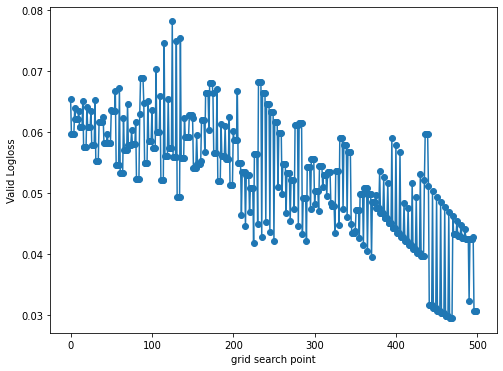

In [197]:
# Plot Loss vs point in grid search
data_out = 'data_xgb_10LungCarcinoma'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss.csv'))
fig, axes = plt.subplots(figsize=(8,6))
axes.scatter(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.plot(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.set_xlabel("grid search point")
axes.set_ylabel("Valid Logloss")
plt.show()

In [198]:
# Train with best hyperparameters
param[0] = ('eta', best_eta)
param[1] = ('max_depth', best_depth)

evals_result = {}
xgb_clf = xgb.train(param, dtrain, 
                    num_boost_round = 5000, 
                    evals = valid_list, 
                    early_stopping_rounds = 10, 
                    verbose_eval = True, 
                    evals_result=evals_result)

[0]	train-logloss:0.20210	valid-logloss:0.26430
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[1]	train-logloss:0.09403	valid-logloss:0.13412
[2]	train-logloss:0.05447	valid-logloss:0.07305
[3]	train-logloss:0.03507	valid-logloss:0.04538
[4]	train-logloss:0.02441	valid-logloss:0.02957
[5]	train-logloss:0.02441	valid-logloss:0.02959
[6]	train-logloss:0.02441	valid-logloss:0.02960
[7]	train-logloss:0.02441	valid-logloss:0.02960
[8]	train-logloss:0.02441	valid-logloss:0.02960
[9]	train-logloss:0.02441	valid-logloss:0.02960
[10]	train-logloss:0.02441	valid-logloss:0.02960
[11]	train-logloss:0.02441	valid-logloss:0.02960
[12]	train-logloss:0.02441	valid-logloss:0.02960
[13]	train-logloss:0.02441	valid-logloss:0.02960
[14]	train-logloss:0.02441	valid-logloss:0.02960
Stopping. Best iteration:
[4]	train-logloss:0.02441	valid-logloss:0.02957



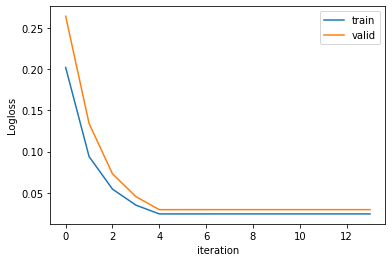

In [199]:
# Plot of train/valid loss vs iter
fig, axes = plt.subplots(figsize=(6,4))
axes.plot(evals_result['train']['logloss'], label="train")
axes.plot(evals_result['valid']['logloss'], label="valid")
axes.legend()
axes.set_ylabel("Logloss")
axes.set_xlabel("iteration")
# axes.set_xticks(np.arange(0, len(evals_result['train']['logloss']), 1))
plt.show()

<AxesSubplot:>

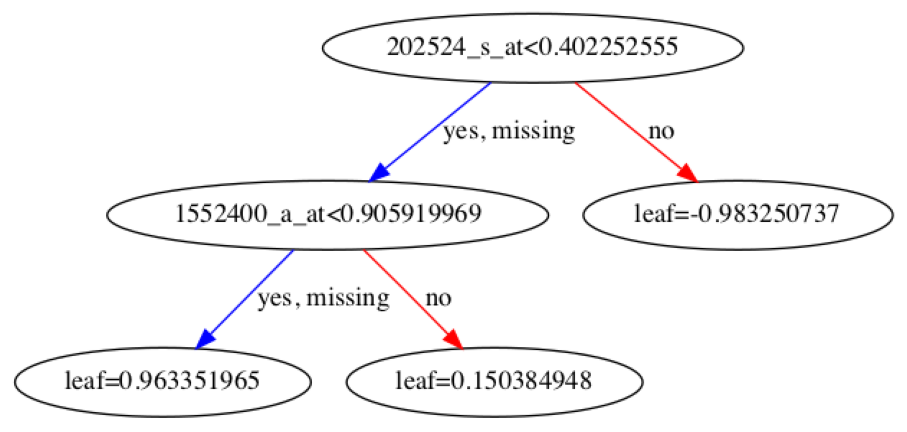

In [203]:
# Plot a tree
fig, axes = plt.subplots(figsize=(16,12))
plot_tree(xgb_clf, ax=axes, num_trees=1)

In [47]:
# Save model and model's best params
data_out = 'data_xgb_10LungCarcinoma'
xgb_clf.save_model(os.path.join(data_out, 'xgb_model_val.json'))
print("model saved at: '{}'".format(os.path.join(data_out, 'xgb_model_val.json')))

best_params = {}
best_params['best_eta'] = best_eta
best_params['best_depth'] = int(best_depth)
with open(os.path.join(data_out, 'xgb_best_params_val.json'), 'w') as f:
    json.dump(best_params, f)
print("best params saved at: '{}'".format(os.path.join(data_out, 'xgb_best_params_val.json')))

model saved at: 'data_xgb_10LungCarcinoma/xgb_model_val.json'
best params saved at: 'data_xgb_10LungCarcinoma/xgb_best_params_val.json'


In [48]:
# Save feature map
def ceate_feature_map(features, data_out):
    f = open(os.path.join(data_out, 'xgb_model_fmap.txt'), 'w')
    i = 0
    for feat in features:
        f.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    f.close()

data_out = 'data_xgb_10LungCarcinoma'
ceate_feature_map(cols_all, data_out)
print("feature map saved at: '{}'".format(os.path.join(data_out, 'xgb_model_fmap.txt')))

feature map saved at: 'data_xgb_10LungCarcinoma/xgb_model_fmap.txt'


In [49]:
# Find MSE, R2, Accuracy, etc...
data_out = 'data_xgb_10LungCarcinoma'
model = xgb.Booster(model_file=os.path.join(data_out, 'xgb_model_val.json'))
df_results = pd.DataFrame(index=['train', 'valid', 'test'], 
                           columns=['accuracy', 'roc_auc'])

ypred = model.predict(dtrain)
ypred = ypred.round().astype(int)
df_results.loc['train', 'accuracy'] = accuracy_score(ytrain, ypred)
df_results.loc['train', 'roc_auc']  = roc_auc_score(ytrain, ypred)

ypred = model.predict(dvalid)
ypred = ypred.round().astype(int)
df_results.loc['valid', 'accuracy'] = accuracy_score(yvalid, ypred)
df_results.loc['valid', 'roc_auc']  = roc_auc_score(yvalid, ypred)

ypred = model.predict(dtest)
ypred = ypred.round().astype(int)
df_results.loc['test', 'accuracy'] = accuracy_score(ytest, ypred)
df_results.loc['test', 'roc_auc']  = roc_auc_score(ytest, ypred)

# Save data
df_results.to_csv(os.path.join(data_out, 'results_target_xgb_val.csv'), index=True)
print("model results saved at: '{}'".format(os.path.join(data_out, 'results_target_xgb_val.csv')))
df_results.head()

model results saved at: 'data_xgb_10LungCarcinoma/results_target_xgb_val.csv'


,accuracy,roc_auc
train,1,1
valid,1,1
test,0.916667,0.9


In [51]:
# Find Accuracy +/- STD
data_out = 'data_xgb_10LungCarcinoma'
df_results = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 'train_roc', 'valid_roc', 'test_roc'])

with open(os.path.join(data_out, 'xgb_best_params_val.json')) as f:
    best_params = json.load(f)
param = [('eta', best_params['best_eta']), 
         ('max_depth', best_params['best_depth']), 
         ('objective', 'binary:logistic'), 
         ('nthread', 16),
         ('eval_metric', 'logloss')
]

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])
    
# .build DMatrices
    dtrain = xgb.DMatrix(data=xtrain, label=ytrain, nthread=16)
    dvalid = xgb.DMatrix(data=xvalid, label=yvalid, nthread=16)
    dtest  = xgb.DMatrix(data=xtest,  label=ytest,  nthread=16)
    valid_list = [(dtrain, 'train'), (dvalid, 'valid')]

# .train model
    evals_result = {}
    model = xgb.train(param, dtrain, 
                      num_boost_round = 5000, 
                      evals = valid_list, 
                      early_stopping_rounds = 20, 
                      verbose_eval = False, 
                      evals_result=evals_result)
    
# .compute/save accuracy
    ypred = model.predict(dtrain)
    ypred = ypred.round().astype(int)
    df_results.loc[n, 'train_acc'] = accuracy_score(ytrain, ypred)
    df_results.loc[n, 'train_roc']  = roc_auc_score(ytrain, ypred)

    ypred = model.predict(dvalid)
    ypred = ypred.round().astype(int)
    df_results.loc[n, 'valid_acc'] = accuracy_score(yvalid, ypred)
    df_results.loc[n, 'valid_roc']  = roc_auc_score(yvalid, ypred)

    ypred = model.predict(dtest)
    ypred = ypred.round().astype(int)
    df_results.loc[n, 'test_acc'] = accuracy_score(ytest, ypred)
    df_results.loc[n, 'test_roc']  = roc_auc_score(ytest, ypred)

    model.save_model(os.path.join(data_out, 'xgb_model_val_'+str(n)+'.json'))
    df_results.to_csv(os.path.join(data_out, 'accuracy10_xgb_val.csv'), index=None)

In [52]:
# Display results
data_out = 'data_xgb_10LungCarcinoma'
accuracy_xgb = pd.read_csv(os.path.join(data_out, 'accuracy_xgb_val.csv'))
print("Train accuracy = {:.3f} +/- {:.3f}".format(accuracy_xgb['train_acc'].mean(), 
                                                  accuracy_xgb['train_acc'].std()))
print("Valid accuracy = {:.3f} +/- {:.3f}".format(accuracy_xgb['valid_acc'].mean(), 
                                                  accuracy_xgb['valid_acc'].std()))
print("Test accuracy = {:.3f} +/- {:.3f}".format(accuracy_xgb['test_acc'].mean(), 
                                                 accuracy_xgb['test_acc'].std()))

Train accuracy = 1.000 +/- 0.000
Valid accuracy = 0.930 +/- 0.060
Test accuracy = 0.928 +/- 0.057


* ### Lockdown

In [22]:
# Normalize Data Set
def normalize_data():
    """
    """
    global xtrain, xvalid, xtest
    scaler = StandardScaler()
    scaler.fit(xtrain.numpy())
    xtrain = torch.from_numpy(scaler.transform(xtrain.numpy()))
    xvalid = torch.from_numpy(scaler.transform(xvalid.numpy()))
    xtest = torch.from_numpy(scaler.transform(xtest.numpy()))

In [23]:
# Save output data
def save_output(data_out, f1, f2, f3, new_folder=False):
    """
    """
# Save relevant data
    if new_folder == True:
        dirs = os.listdir()
        if data_out in dirs:
            print("'{}' directory deleted.".format(data_out))
            shutil.rmtree(data_out)
            print("'{}' directory created.\n".format(data_out))
            os.mkdir(data_out)
        else:
            print("'{}' directory created.\n".format(data_out))
            os.mkdir(data_out)
# 
    train_loss.to_csv(os.path.join(data_out, f1), index=False)
    valid_loss.to_csv(os.path.join(data_out, f2), index=False)
    print("'{}' saved.".format(f1))
    print("'{}' saved.".format(f2))

    for m in f3:
        shutil.move(m, os.path.join(data_out, m))
        print("'{}' saved.".format(m))

* #### l1=5, l2=2; lockdown=l1

In [24]:
# Set layers where lockdown is to be applied
def get_lockdown_layers(model):
    layers = [model.classifier[0]]
    return layers

In [25]:
#  NN architecture with its corresponding forward method
class MyNet(nn.Module):
    
# .Network architecture
    def __init__(self, features, layer_sizes):
        super(MyNet, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(features, layer_sizes[0], bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(layer_sizes[0], layer_sizes[1], bias=True)
        )

# .Forward function
    def forward(self, x):
        x = self.classifier(x)
        return x

In [87]:
# Grid search space
grid_lrs = np.geomspace(5e-4, 1e-1, num=10)
df_grid_loss = pd.DataFrame(columns = ['lr', 'valid_loss', 'valid_acc'], 
                            index=range(len(grid_lrs)))

In [90]:
# Perform grid search (unconstrained)
layer_sizes = [5, 2]
epochs = 20000
data_in = 'dataset_10LungCarcinoma'
data_out = "data_unconstrained_10LungCarcinoma"
lock_flag = False

# Read data
load_data(data_in)

# Normalize data
normalize_data()

# Create DataLoaders
make_DataLoaders()
features = xtrain.size(1)

# Train model
iterator = tqdm.notebook.tqdm(range(1, len(grid_lrs) + 1), desc='lr-grid loop')
for n in iterator:
    irow = n-1
    fname = 'model10_forward05_'+str(n)
    train_loss, valid_loss = train_model(
                             grid_lrs[irow], 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs=epochs,
                             early_stop=epochs, 
                             fname=fname)
    print('\nBest train loss = {:.7f}\n'.format(train_loss['loss'].min()))

# .save relevant data
    f3 = [fname+'_last.pth', fname+'_best.pth']
    save_output(data_out, 
                'train_loss05_'+str(n)+'.csv', 
                'valid_loss05_'+str(n)+'.csv', f3)
    
# .find MSE, R2, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()

# .save grid search results
    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    df_grid_loss.iloc[irow,:] = [grid_lrs[irow], loss.detach().item(), accu]
    df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_forward05.csv'), index=None)

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


lr-grid loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00050
-Model saved after iteration 20000.
-Train.  Loss=0.0135803
-Valid.  Loss=0.0098447

Best train loss = 0.0135803

'train_loss05_1.csv' saved.
'valid_loss05_1.csv' saved.
'model10_forward05_1_last.pth' saved.
'model10_forward05_1_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00090
-Model saved after iteration 19578.
-Train.  Loss=0.0251933
-Valid.  Loss=0.0017510

Best train loss = 0.0248840

'train_loss05_2.csv' saved.
'valid_loss05_2.csv' saved.
'model10_forward05_2_last.pth' saved.
'model10_forward05_2_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-Model saved after iteration 18989.
-Train.  Loss=0.0271896
-Valid.  Loss=0.0034851

Best train loss = 0.0271481

'train_loss05_3.csv' saved.
'valid_loss05_3.csv' saved.
'model10_forward05_3_last.pth' saved.
'model10_forward05_3_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 20000.
-Train.  Loss=0.0062225
-Valid.  Loss=0.0046508

Best train loss = 0.0062225

'train_loss05_4.csv' saved.
'valid_loss05_4.csv' saved.
'model10_forward05_4_last.pth' saved.
'model10_forward05_4_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 18290.
-Train.  Loss=0.0047238
-Valid.  Loss=0.0214368

Best train loss = 0.0044053

'train_loss05_5.csv' saved.
'valid_loss05_5.csv' saved.
'model10_forward05_5_last.pth' saved.
'model10_forward05_5_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00949
-Model saved after iteration 20000.
-Train.  Loss=0.0028828
-Valid.  Loss=0.0049827

Best train loss = 0.0028828

'train_loss05_6.csv' saved.
'valid_loss05_6.csv' saved.
'model10_forward05_6_last.pth' saved.
'model10_forward05_6_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.01710
-Model saved after iteration 7206.
-Train.  Loss=0.0193458
-Valid.  Loss=0.0260214

Best train loss = 0.0192582

'train_loss05_7.csv' saved.
'valid_loss05_7.csv' saved.
'model10_forward05_7_last.pth' saved.
'model10_forward05_7_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.03081
-Model saved after iteration 20000.
-Train.  Loss=0.0000021
-Valid.  Loss=0.0031025

Best train loss = 0.0000021

'train_loss05_8.csv' saved.
'valid_loss05_8.csv' saved.
'model10_forward05_8_last.pth' saved.
'model10_forward05_8_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 20000.
-Train.  Loss=0.0000006
-Valid.  Loss=0.0003961

Best train loss = 0.0000006

'train_loss05_9.csv' saved.
'valid_loss05_9.csv' saved.
'model10_forward05_9_last.pth' saved.
'model10_forward05_9_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-Model saved after iteration 193.
-Train.  Loss=0.0109547
-Valid.  Loss=0.0063389

Best train loss = 0.0002563

'train_loss05_10.csv' saved.
'valid_loss05_10.csv' saved.
'model10_forward05_10_last.pth' saved.
'model10_forward05_10_best.pth' saved.


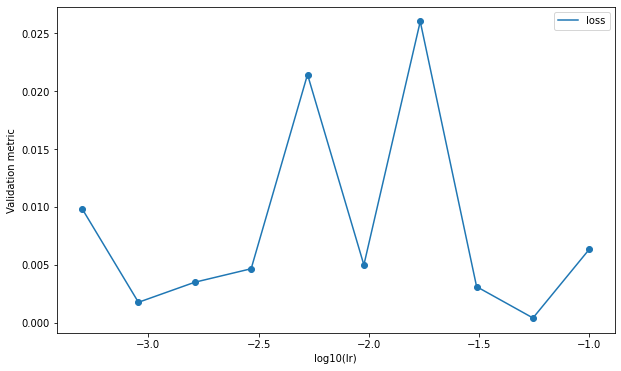

In [92]:
# Plot Loss vs point in grid search
data_out = "data_unconstrained_10LungCarcinoma/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_forward05.csv'))
fig, axes = plt.subplots(figsize=(10,6))
axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_loss'])
axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_loss'], label='loss')
# axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'])
# axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'], label='r2')
axes.set_xlabel("log10(lr)")
axes.set_ylabel("Validation metric")
axes.legend()
plt.show()

In [234]:
# Display grid search results
data_out = "data_unconstrained_10LungCarcinoma/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_forward05.csv'))

idx = df_grid_loss.valid_loss.idxmin()
best_lr_fward = df_grid_loss.iloc[idx, 0]
best_mse      = df_grid_loss.iloc[idx, 1]
print("Best parameters ({}):".format(idx+1))
print("- Best lr = {:.5f}".format(best_lr_fward))
print("- Best valid loss = {}".format(best_mse))

# Copy best model to main directory
shutil.copy("data_unconstrained_10LungCarcinoma/lrs/model10_forward05_"+str(idx+1)+"_best.pth", 
            "data_unconstrained_10LungCarcinoma/model10_forward05_best.pth")
shutil.copy("data_unconstrained_10LungCarcinoma/lrs/model10_forward05_"+str(idx+1)+"_last.pth", 
            "data_unconstrained_10LungCarcinoma/model10_forward05_last.pth")

shutil.copy("data_unconstrained_10LungCarcinoma/lrs/train_loss05_"+str(idx+1)+".csv", 
            "data_unconstrained_10LungCarcinoma/train_loss05.csv")
shutil.copy("data_unconstrained_10LungCarcinoma/lrs/valid_loss05_"+str(idx+1)+".csv", 
            "data_unconstrained_10LungCarcinoma/valid_loss05.csv")

Best parameters (9):
- Best lr = 0.05550
- Best valid loss = 0.00039606308564543724


'data_unconstrained_10LungCarcinoma/valid_loss05.csv'

In [97]:
# Grid search space
grid_lrs = np.geomspace(5e-4, 1e-1, num=10)
df_grid_loss = pd.DataFrame(columns = ['lr', 'valid_loss', 'valid_acc'], 
                            index=range(len(grid_lrs)))

In [98]:
# Perform grid search (lockdown: path 2)
layer_sizes = [5, 2]
epochs = 10000
data_in = 'dataset_10LungCarcinoma'
data_out = "data_lockdown_10LungCarcinoma/lrs"
lock_flag = True
step = 1

# Read data
load_data(data_in)

# Normalize data
normalize_data()

# Create DataLoaders
make_DataLoaders()
features = xtrain.size(1)

# Train model
iterator = tqdm.notebook.tqdm(range(1, len(grid_lrs) + 1), desc='lr-grid loop')
for n in iterator:
    irow = n-1
    model_forward_name = 'data_unconstrained_10LungCarcinoma/lrs/model10_forward05_'+str(n)+'_last.pth'
    fname = 'model10_backward05_'+str(n)
    train_loss, valid_loss = train_model(
                             grid_lrs[irow], 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs=epochs,
                             early_stop=epochs, 
                             fname=fname)
    print('\nBest train loss = {:.7f}\n'.format(train_loss['loss'].min()))

# .save relevant data
    f3 = [fname+'_best.pth']
    save_output(data_out, 
                'train_loss05_'+str(n)+'.csv', 
                'valid_loss05_'+str(n)+'.csv', f3)
    
# .find MSE, R2, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()

# .save grid search results
    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    df_grid_loss.iloc[irow,:] = [grid_lrs[irow], loss.detach().item(), accu]
    df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_backward05.csv'), index=None)

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


lr-grid loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00050
-Model saved after iteration 187.
-Train.  Loss=0.0133876
-Valid.  Loss=0.0000343

Best train loss = 0.0128236

'train_loss05_1.csv' saved.
'valid_loss05_1.csv' saved.
'model10_backward05_1_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00090
-Model saved after iteration 69.
-Train.  Loss=0.0247473
-Valid.  Loss=0.0000000

Best train loss = 0.0108573

'train_loss05_2.csv' saved.
'valid_loss05_2.csv' saved.
'model10_backward05_2_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00162
-Model saved after iteration 33.
-Train.  Loss=0.0000000
-Valid.  Loss=0.0000045

Best train loss = 0.0000000

'train_loss05_3.csv' saved.
'valid_loss05_3.csv' saved.
'model10_backward05_3_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00292
-Model saved after iteration 29.
-Train.  Loss=0.0000594
-Valid.  Loss=0.0000015

Best train loss = 0.0000000

'train_loss05_4.csv' saved.
'valid_loss05_4.csv' saved.
'model10_backward05_4_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 1232.
-Train.  Loss=0.0000000
-Valid.  Loss=0.0000000

Best train loss = 0.0000000

'train_loss05_5.csv' saved.
'valid_loss05_5.csv' saved.
'model10_backward05_5_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00949
-Model saved after iteration 579.
-Train.  Loss=0.0027389
-Valid.  Loss=0.0000000

Best train loss = 0.0019060

'train_loss05_6.csv' saved.
'valid_loss05_6.csv' saved.
'model10_backward05_6_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.01710
-Model saved after iteration 299.
-Train.  Loss=0.0000007
-Valid.  Loss=0.0000000

Best train loss = 0.0000000

'train_loss05_7.csv' saved.
'valid_loss05_7.csv' saved.
'model10_backward05_7_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.03081
-Model saved after iteration 134.
-Train.  Loss=0.0000001
-Valid.  Loss=0.0000000

Best train loss = 0.0000000

'train_loss05_8.csv' saved.
'valid_loss05_8.csv' saved.
'model10_backward05_8_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 34.
-Train.  Loss=0.0601776
-Valid.  Loss=0.0000000

Best train loss = 0.0000000

'train_loss05_9.csv' saved.
'valid_loss05_9.csv' saved.
'model10_backward05_9_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.10000
-Model saved after iteration 1.
-Train.  Loss=0.0002563
-Valid.  Loss=0.0173571

Best train loss = 0.0002563

'train_loss05_10.csv' saved.
'valid_loss05_10.csv' saved.
'model10_backward05_10_best.pth' saved.


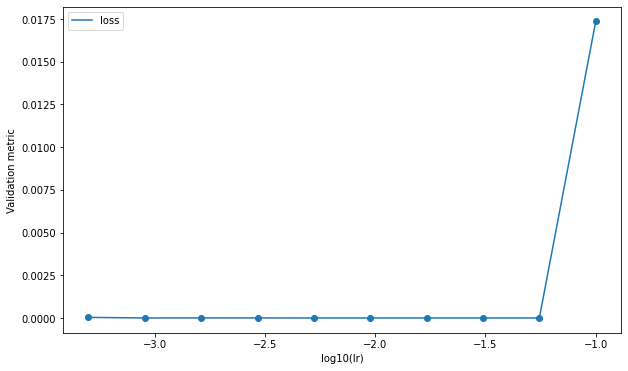

In [107]:
# Plot Loss vs point in grid search
data_out = "data_lockdown_10LungCarcinoma/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_backward05.csv'))
fig, axes = plt.subplots(figsize=(10,6))
axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_loss'])
axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_loss'], label='loss')
# axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'])
# axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'], label='r2')
axes.set_xlabel("log10(lr)")
axes.set_ylabel("Validation metric")
axes.legend()
plt.show()

In [235]:
# Display grid search results
data_out = "data_lockdown_10LungCarcinoma/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_backward05.csv'))

idx = df_grid_loss.valid_loss.idxmin()
idx = 4
best_lr_bward = df_grid_loss.iloc[idx, 0]
best_mse      = df_grid_loss.iloc[idx, 1]
print("Best parameters ({}):".format(idx+1))
print("- Best lr = {:.5f}".format(best_lr_bward))
print("- Best valid loss = {}".format(best_mse))

# Copy best models to main directory
shutil.copy("data_unconstrained_10LungCarcinoma/lrs/model10_forward05_"+str(idx+1)+"_best.pth", 
            "data_lockdown_10LungCarcinoma/model10_fward05_best.pth")
shutil.copy("data_unconstrained_10LungCarcinoma/lrs/model10_forward05_"+str(idx+1)+"_last.pth", 
            "data_lockdown_10LungCarcinoma/model10_fward05_last.pth")
shutil.copy("data_lockdown_10LungCarcinoma/lrs/model10_backward05_"+str(idx+1)+"_best.pth", 
            "data_lockdown_10LungCarcinoma/model10_backward05_best.pth")

shutil.copy("data_unconstrained_10LungCarcinoma/lrs/train_loss05_"+str(idx+1)+".csv", 
            "data_lockdown_10LungCarcinoma/train_loss_fward05.csv")
shutil.copy("data_unconstrained_10LungCarcinoma/lrs/valid_loss05_"+str(idx+1)+".csv", 
            "data_lockdown_10LungCarcinoma/valid_loss_fward05.csv")
shutil.copy("data_lockdown_10LungCarcinoma/lrs/train_loss05_"+str(idx+1)+".csv", 
            "data_lockdown_10LungCarcinoma/train_loss05.csv")
shutil.copy("data_lockdown_10LungCarcinoma/lrs/valid_loss05_"+str(idx+1)+".csv", 
            "data_lockdown_10LungCarcinoma/valid_loss05.csv")

Best parameters (5):
- Best lr = 0.00527
- Best valid loss = 0.0


'data_lockdown_10LungCarcinoma/valid_loss05.csv'

In [156]:
# Find Loss, Accuracy, etc...
data_out = "data_lockdown_10LungCarcinoma"
index = pd.MultiIndex.from_product([['TRAIN', 'VALIDATION', 'TEST'], ['forward', 'lockdown']])
df_results = pd.DataFrame(index=index, columns=['LOSS', 'ACCURACY'])

# Unconstrained results
mm = MyNet(features, layer_sizes)
mm.load_state_dict(torch.load('data_unconstrained_10LungCarcinoma/model10_forward05_best.pth'))
mm = mm.to(device)
mm.eval()

ypred = mm(xtrain)
loss = loss_type(ypred, ytrain.view(-1))
accu = dataset_accuracy(train_dataloader, mm, device)
df_results.loc[('TRAIN', 'forward'), 'LOSS'] = loss.detach().item()
df_results.loc[('TRAIN', 'forward'), 'ACCURACY'] = accu

ypred = mm(xvalid)
loss = loss_type(ypred, yvalid.view(-1))
accu = dataset_accuracy(valid_dataloader, mm, device)
df_results.loc[('VALIDATION', 'forward'), 'LOSS'] = loss.detach().item()
df_results.loc[('VALIDATION', 'forward'), 'ACCURACY'] = accu

ypred = mm(xtest)
loss = loss_type(ypred, ytest.view(-1))
accu = dataset_accuracy(test_dataloader, mm, device)
df_results.loc[('TEST', 'forward'), 'LOSS'] = loss.detach().item()
df_results.loc[('TEST', 'forward'), 'ACCURACY'] = accu

# Lockdown results
mm = MyNet(features, layer_sizes)
mm.load_state_dict(torch.load('data_lockdown_10LungCarcinoma/model10_backward05_best.pth'))
mm = mm.to(device)
mm.eval()

ypred = mm(xtrain)
loss = loss_type(ypred, ytrain.view(-1))
accu = dataset_accuracy(train_dataloader, mm, device)
df_results.loc[('TRAIN', 'lockdown'), 'LOSS'] = loss.detach().item()
df_results.loc[('TRAIN', 'lockdown'), 'ACCURACY'] = accu

ypred = mm(xvalid)
loss = loss_type(ypred, yvalid.view(-1))
accu = dataset_accuracy(valid_dataloader, mm, device)
df_results.loc[('VALIDATION', 'lockdown'), 'LOSS'] = loss.detach().item()
df_results.loc[('VALIDATION', 'lockdown'), 'ACCURACY'] = accu

ypred = mm(xtest)
loss = loss_type(ypred, ytest.view(-1))
accu = dataset_accuracy(test_dataloader, mm, device)
df_results.loc[('TEST', 'lockdown'), 'LOSS'] = loss.detach().item()
df_results.loc[('TEST', 'lockdown'), 'ACCURACY'] = accu

df_results.to_csv(os.path.join(data_out, 'results05.csv'), index=True)
df_results

LOSS  ACCURACY
TRAIN      forward    5.9439e-07         1
           lockdown            0         1
VALIDATION forward   0.000396063         1
           lockdown            0         1
TEST       forward      0.872922  0.916667
           lockdown     0.785675  0.916667

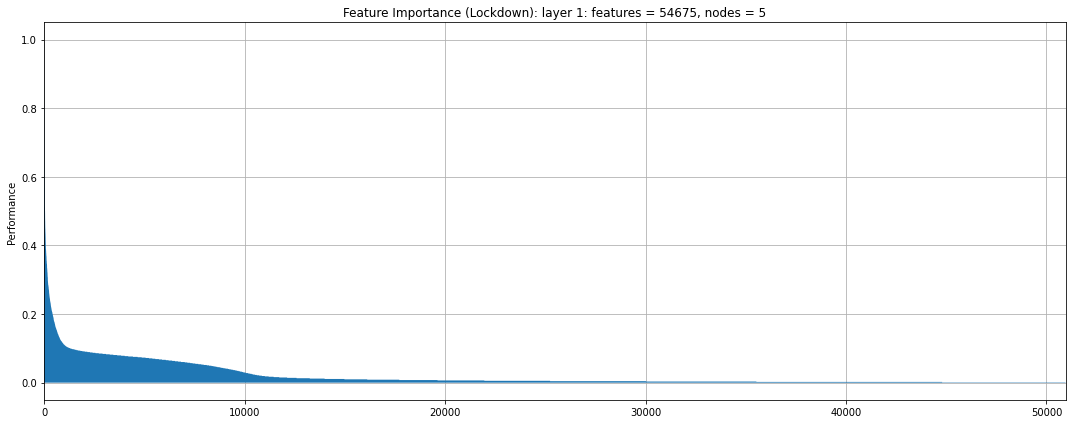

Feature importance graph saved at: 'data_lockdown_10LungCarcinoma/feature_importance05.pdf'
feature importance .csv saved at: 'data_lockdown_10LungCarcinoma/feature_importance_lockdown05.csv'


In [26]:
# Weight importance (Lockdown: layer 1)
target_idx = 1
data_out = "data_lockdown_10LungCarcinoma"
layer_sizes = [5, 2]
m1 = torch.load('data_lockdown_10LungCarcinoma/model10_backward05_best.pth')
feature_importance1 = pd.Series(abs(m1['classifier.0.weight']).sum(dim=0), index=cols_all)
feature_importance1 = feature_importance1/feature_importance1.max()
feature_importance_sorted1 = feature_importance1.sort_values(ascending=False)

idx = feature_importance_sorted1 >= 1e-4

fig, axes = plt.subplots(figsize=(15,6))
x_pos = np.arange(idx.sum())
axes.fill_between(x_pos, 0, feature_importance_sorted1[idx], zorder=2)
# axes.set_xticks(x_pos)
# axes.set_xticklabels(feature_importance_sorted1.index[idx], rotation='vertical')
axes.set_xlim(-1,idx.sum())
axes.set_ylabel('Performance')
axes.set_title('Feature Importance (Lockdown): layer 1: features = {}, nodes = {}'.format(n_features, 
                                                                                          layer_sizes[0]))
axes.grid(True, zorder=1)

plt.tight_layout()
plt.savefig(os.path.join(data_out, 'feature_importance05.pdf'), bbox_inches='tight')
plt.show()
print("Feature importance graph saved at: '{}'".format(os.path.join(data_out, 'feature_importance05.pdf')))

feature_importance_sorted1.to_csv(os.path.join(data_out, 'feature_importance_lockdown05.csv'))
print("feature importance .csv saved at: '{}'".format(os.path.join(data_out, 'feature_importance_lockdown05.csv')))

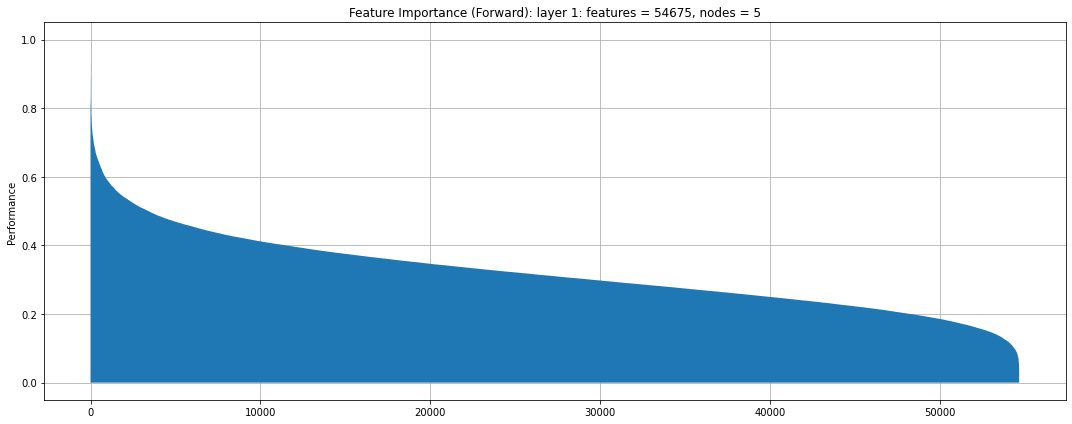

Feature importance graph saved at: 'data_unconstrained_10LungCarcinoma/feature_importance05.pdf'
feature importance .csv saved at: 'data_unconstrained_10LungCarcinoma/feature_importance_forward05.csv'


In [27]:
# Weight importance (Forward: layer 1)
target_idx = 1
data_out = "data_unconstrained_10LungCarcinoma"
layer_sizes = [5, 2]
m1 = torch.load('data_unconstrained_10LungCarcinoma/model10_forward05_best.pth')
feature_importance1 = pd.Series(abs(m1['classifier.0.weight']).sum(dim=0), index=cols_all)
feature_importance1 = feature_importance1/feature_importance1.max()
feature_importance_sorted1 = feature_importance1.sort_values(ascending=False)

idx = feature_importance_sorted1 >= 0

fig, axes = plt.subplots(figsize=(15,6))
x_pos = np.arange(idx.sum())
axes.fill_between(x_pos, 0, feature_importance_sorted1[idx], zorder=2, lw=3)
# axes.set_xticks(x_pos)
# axes.set_xticklabels(feature_importance_sorted1.index[idx], rotation='vertical')
# axes.set_xlim(-1,idx.sum())
axes.set_ylabel('Performance')
axes.set_title('Feature Importance (Forward): layer 1: features = {}, nodes = {}'.format(n_features, 
                                                                                          layer_sizes[0]))
axes.grid(True, zorder=1)

plt.tight_layout()
plt.savefig(os.path.join(data_out, 'feature_importance05.pdf'), bbox_inches='tight')
plt.show()
print("Feature importance graph saved at: '{}'".format(os.path.join(data_out, 'feature_importance05.pdf')))

feature_importance_sorted1.to_csv(os.path.join(data_out, 'feature_importance_forward05.csv'))
print("feature importance .csv saved at: '{}'".format(os.path.join(data_out, 'feature_importance_forward05.csv')))

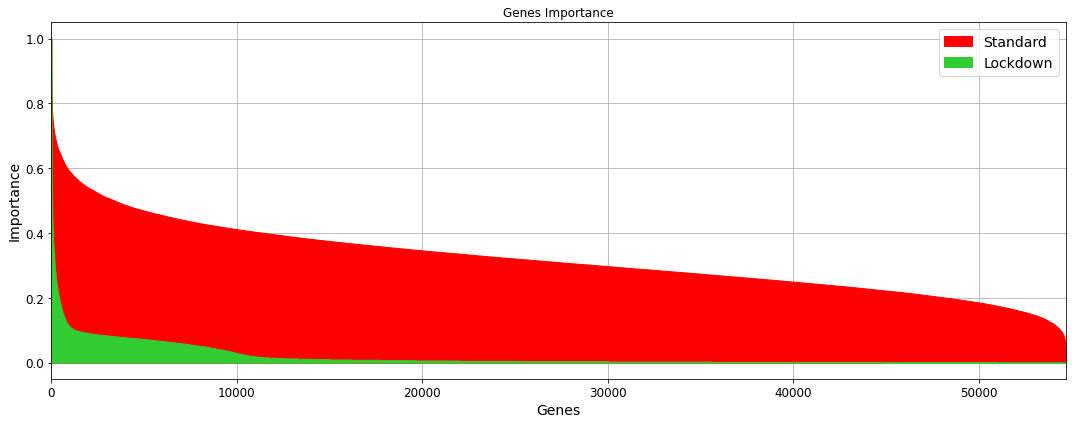

In [28]:
# Gene importance
data_out = "data_lockdown_10LungCarcinoma"
m1 = torch.load('data_lockdown_10LungCarcinoma/model10_backward05_best.pth')
feature_importance1 = pd.Series(abs(m1['classifier.0.weight']).sum(dim=0), index=cols_all)
feature_importance1 = feature_importance1/feature_importance1.max()
feature_importance_sorted1 = feature_importance1.sort_values(ascending=False)
idx1 = feature_importance_sorted1 >= 0

data_out = "data_unconstrained_10LungCarcinoma"
m2 = torch.load('data_unconstrained_10LungCarcinoma/model10_forward05_best.pth')
feature_importance2 = pd.Series(abs(m2['classifier.0.weight']).sum(dim=0), index=cols_all)
feature_importance2 = feature_importance2/feature_importance2.max()
feature_importance_sorted2 = feature_importance2.sort_values(ascending=False)
idx2 = feature_importance_sorted2 >= 0

fig, axes = plt.subplots(figsize=(15,6))
x_pos = np.arange(idx2.sum())
axes.fill_between(x_pos, 0, feature_importance_sorted2[idx2], label='Standard', zorder=2, color='red')
axes.fill_between(x_pos, 0, feature_importance_sorted1[idx1], label='Lockdown', zorder=2, color='limegreen')
axes.set_xlim(-1,idx.sum())
axes.set_ylabel('Importance', fontsize=14)
axes.set_xlabel('Genes', fontsize=14)
# axes.set_title('Genes Importance: genes = {}'.format(features), fontsize=14)
axes.set_title('Genes Importance')
axes.legend(fontsize=14)
axes.grid(True, zorder=1)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join("data_lockdown_10LungCarcinoma", 'feature_importance.pdf'), bbox_inches='tight')
plt.show()
# print("Feature importance graph saved at: '{}'".format(os.path.join(data_out, 'feature_importance05.pdf')))

# feature_importance_sorted1.to_csv(os.path.join(data_out, 'feature_importance_lockdown05.csv'))
# print("feature importance .csv saved at: '{}'".format(os.path.join(data_out, 'feature_importance_lockdown05.csv')))

In [163]:
# Find Accuracy, Loss +/- STD (Forward)
data_output = 'data_unconstrained_10LungCarcinoma'
accuracy_forward = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 
                                         'train_loss', 'valid_loss', 'test_loss'])

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_10LungCarcinoma/X.csv', header=None)
    y = pd.read_csv('dataset_10LungCarcinoma/y.csv', header=None)
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])

# .normalize data sets
    df_to_tensor()
    normalize_data()
    make_DataLoaders()

# .train model (forward)
    lr = best_lr_fward
    layer_sizes = [5, 2]
    epochs = 20000
    data_out = "data_unconstrained_10LungCarcinoma/partitions"
    lock_flag = False
    features = xtrain.size(1)
    fname = 'model10_forward05_'+str(n)
    train_loss, valid_loss = train_model(
                             lr, 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs = epochs,
                             early_stop = 4000, 
                             fname = fname)
# .save relevant data
    f3 = [fname+'_last.pth', fname+'_best.pth']
    save_output(data_out, 
                'train_loss05_'+str(n)+'.csv', 
                'valid_loss05_'+str(n)+'.csv', f3)

# .find Loss, Accurary, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()
    
    ypred = mm(xtrain)
    loss = loss_type(ypred, ytrain.view(-1))
    accu = dataset_accuracy(train_dataloader, mm, device)
    accuracy_forward.loc[n, 'train_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'train_acc'] = accu

    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    accuracy_forward.loc[n, 'valid_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'valid_acc'] = accu

    ypred = mm(xtest)
    loss = loss_type(ypred, ytest.view(-1))
    accu = dataset_accuracy(test_dataloader, mm, device)
    accuracy_forward.loc[n, 'test_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'test_acc'] = accu

    accuracy_forward.to_csv(os.path.join(data_out, 'accuracy10_forward05.csv'), index=True)

Partitions loop:   0%|          | 0/100 [00:00<?, ?it/s]

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 802.
-Train.  Loss=0.0050907
-Valid.  Loss=0.1322764
'train_loss05_1.csv' saved.
'valid_loss05_1.csv' saved.
'model10_forward05_1_last.pth' saved.
'model10_forward05_1_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.7413365
-Valid.  Loss=0.8313867
'train_loss05_2.csv' saved.
'valid_loss05_2.csv' saved.
'model10_forward05_2_last.pth' saved.
'model10_forward05_2_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 4.
-Train.  Loss=0.1006961
-Valid.  Loss=0.4563310
'train_loss05_3.csv' saved.
'valid_loss05_3.csv' saved.
'model10_forward05_3_last.pth' saved.
'model10_forward05_3_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 3.
-Train.  Loss=0.1399562
-Valid.  Loss=0.0565629
'train_loss05_4.csv' saved.
'valid_loss05_4.csv' saved.
'model10_forward05_4_last.pth' saved.
'model10_forward05_4_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.8045654
-Valid.  Loss=0.7588447
'train_loss05_5.csv' saved.
'valid_loss05_5.csv' saved.
'model10_forward05_5_last.pth' saved.
'model10_forward05_5_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 2.
-Train.  Loss=0.6923080
-Valid.  Loss=0.2701603
'train_loss05_6.csv' saved.
'valid_loss05_6.csv' saved.
'model10_forward05_6_last.pth' saved.
'model10_forward05_6_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 409.
-Train.  Loss=0.0093874
-Valid.  Loss=0.0646212
'train_loss05_7.csv' saved.
'valid_loss05_7.csv' saved.
'model10_forward05_7_last.pth' saved.
'model10_forward05_7_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 8723.
-Train.  Loss=0.0011059
-Valid.  Loss=0.0113723
'train_loss05_8.csv' saved.
'valid_loss05_8.csv' saved.
'model10_forward05_8_last.pth' saved.
'model10_forward05_8_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.6968183
-Valid.  Loss=0.6532403
'train_loss05_9.csv' saved.
'valid_loss05_9.csv' saved.
'model10_forward05_9_last.pth' saved.
'model10_forward05_9_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 3.
-Train.  Loss=0.0430987
-Valid.  Loss=0.6120726
'train_loss05_10.csv' saved.
'valid_loss05_10.csv' saved.
'model10_forward05_10_last.pth' saved.
'model10_forward05_10_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 3.
-Train.  Loss=0.1903075
-Valid.  Loss=0.5957804
'train_loss05_11.csv' saved.
'valid_loss05_11.csv' saved.
'model10_forward05_11_last.pth' saved.
'model10_forward05_11_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 10257.
-Train.  Loss=0.0192552
-Valid.  Loss=0.0010041
'train_loss05_12.csv' saved.
'valid_loss05_12.csv' saved.
'model10_forward05_12_last.pth' saved.
'model10_forward05_12_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 19206.
-Train.  Loss=0.0004905
-Valid.  Loss=0.0052828
'train_loss05_13.csv' saved.
'valid_loss05_13.csv' saved.
'model10_forward05_13_last.pth' saved.
'model10_forward05_13_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 879.
-Train.  Loss=0.0186452
-Valid.  Loss=0.6692455
'train_loss05_14.csv' saved.
'valid_loss05_14.csv' saved.
'model10_forward05_14_last.pth' saved.
'model10_forward05_14_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 9.
-Train.  Loss=0.0354750
-Valid.  Loss=0.6839622
'train_loss05_15.csv' saved.
'valid_loss05_15.csv' saved.
'model10_forward05_15_last.pth' saved.
'model10_forward05_15_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 6.
-Train.  Loss=0.0395206
-Valid.  Loss=0.2473801
'train_loss05_16.csv' saved.
'valid_loss05_16.csv' saved.
'model10_forward05_16_last.pth' saved.
'model10_forward05_16_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 3.
-Train.  Loss=0.0447947
-Valid.  Loss=0.5419448
'train_loss05_17.csv' saved.
'valid_loss05_17.csv' saved.
'model10_forward05_17_last.pth' saved.
'model10_forward05_17_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 3.
-Train.  Loss=0.1414577
-Valid.  Loss=0.1134328
'train_loss05_18.csv' saved.
'valid_loss05_18.csv' saved.
'model10_forward05_18_last.pth' saved.
'model10_forward05_18_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 20000.
-Train.  Loss=0.0265218
-Valid.  Loss=0.3989471
'train_loss05_19.csv' saved.
'valid_loss05_19.csv' saved.
'model10_forward05_19_last.pth' saved.
'model10_forward05_19_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 2.
-Train.  Loss=0.3504232
-Valid.  Loss=0.3357358
'train_loss05_20.csv' saved.
'valid_loss05_20.csv' saved.
'model10_forward05_20_last.pth' saved.
'model10_forward05_20_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 13.
-Train.  Loss=0.0317763
-Valid.  Loss=0.0633826
'train_loss05_21.csv' saved.
'valid_loss05_21.csv' saved.
'model10_forward05_21_last.pth' saved.
'model10_forward05_21_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.6675731
-Valid.  Loss=0.6598244
'train_loss05_22.csv' saved.
'valid_loss05_22.csv' saved.
'model10_forward05_22_last.pth' saved.
'model10_forward05_22_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 3.
-Train.  Loss=0.1212937
-Valid.  Loss=0.0116992
'train_loss05_23.csv' saved.
'valid_loss05_23.csv' saved.
'model10_forward05_23_last.pth' saved.
'model10_forward05_23_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.7255193
-Valid.  Loss=0.7704609
'train_loss05_24.csv' saved.
'valid_loss05_24.csv' saved.
'model10_forward05_24_last.pth' saved.
'model10_forward05_24_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 2.
-Train.  Loss=0.5313760
-Valid.  Loss=0.4018217
'train_loss05_25.csv' saved.
'valid_loss05_25.csv' saved.
'model10_forward05_25_last.pth' saved.
'model10_forward05_25_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 20000.
-Train.  Loss=0.0005004
-Valid.  Loss=0.0040941
'train_loss05_26.csv' saved.
'valid_loss05_26.csv' saved.
'model10_forward05_26_last.pth' saved.
'model10_forward05_26_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 2.
-Train.  Loss=0.3617542
-Valid.  Loss=0.3739280
'train_loss05_27.csv' saved.
'valid_loss05_27.csv' saved.
'model10_forward05_27_last.pth' saved.
'model10_forward05_27_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 20000.
-Train.  Loss=0.0004074
-Valid.  Loss=0.0130330
'train_loss05_28.csv' saved.
'valid_loss05_28.csv' saved.
'model10_forward05_28_last.pth' saved.
'model10_forward05_28_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 3.
-Train.  Loss=0.1002328
-Valid.  Loss=0.4325794
'train_loss05_29.csv' saved.
'valid_loss05_29.csv' saved.
'model10_forward05_29_last.pth' saved.
'model10_forward05_29_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 212.
-Train.  Loss=0.1222185
-Valid.  Loss=0.2050586
'train_loss05_30.csv' saved.
'valid_loss05_30.csv' saved.
'model10_forward05_30_last.pth' saved.
'model10_forward05_30_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 2.
-Train.  Loss=0.6925607
-Valid.  Loss=0.1929929
'train_loss05_31.csv' saved.
'valid_loss05_31.csv' saved.
'model10_forward05_31_last.pth' saved.
'model10_forward05_31_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 21.
-Train.  Loss=0.0222184
-Valid.  Loss=0.2988527
'train_loss05_32.csv' saved.
'valid_loss05_32.csv' saved.
'model10_forward05_32_last.pth' saved.
'model10_forward05_32_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 2.
-Train.  Loss=1.9429460
-Valid.  Loss=0.0000360
'train_loss05_33.csv' saved.
'valid_loss05_33.csv' saved.
'model10_forward05_33_last.pth' saved.
'model10_forward05_33_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 4.
-Train.  Loss=0.0291140
-Valid.  Loss=0.0929821
'train_loss05_34.csv' saved.
'valid_loss05_34.csv' saved.
'model10_forward05_34_last.pth' saved.
'model10_forward05_34_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.8498368
-Valid.  Loss=0.7834495
'train_loss05_35.csv' saved.
'valid_loss05_35.csv' saved.
'model10_forward05_35_last.pth' saved.
'model10_forward05_35_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 20000.
-Train.  Loss=0.0312416
-Valid.  Loss=0.0048937
'train_loss05_36.csv' saved.
'valid_loss05_36.csv' saved.
'model10_forward05_36_last.pth' saved.
'model10_forward05_36_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.7065368
-Valid.  Loss=0.7438772
'train_loss05_37.csv' saved.
'valid_loss05_37.csv' saved.
'model10_forward05_37_last.pth' saved.
'model10_forward05_37_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 19777.
-Train.  Loss=0.0004626
-Valid.  Loss=0.0000498
'train_loss05_38.csv' saved.
'valid_loss05_38.csv' saved.
'model10_forward05_38_last.pth' saved.
'model10_forward05_38_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 4.
-Train.  Loss=0.0841318
-Valid.  Loss=0.6385001
'train_loss05_39.csv' saved.
'valid_loss05_39.csv' saved.
'model10_forward05_39_last.pth' saved.
'model10_forward05_39_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 3.
-Train.  Loss=0.0287748
-Valid.  Loss=0.4520464
'train_loss05_40.csv' saved.
'valid_loss05_40.csv' saved.
'model10_forward05_40_last.pth' saved.
'model10_forward05_40_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 20000.
-Train.  Loss=0.0265216
-Valid.  Loss=0.3909638
'train_loss05_41.csv' saved.
'valid_loss05_41.csv' saved.
'model10_forward05_41_last.pth' saved.
'model10_forward05_41_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.7525686
-Valid.  Loss=0.6315749
'train_loss05_42.csv' saved.
'valid_loss05_42.csv' saved.
'model10_forward05_42_last.pth' saved.
'model10_forward05_42_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 2.
-Train.  Loss=1.0676702
-Valid.  Loss=0.0119810
'train_loss05_43.csv' saved.
'valid_loss05_43.csv' saved.
'model10_forward05_43_last.pth' saved.
'model10_forward05_43_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 3.
-Train.  Loss=0.1564080
-Valid.  Loss=0.4538931
'train_loss05_44.csv' saved.
'valid_loss05_44.csv' saved.
'model10_forward05_44_last.pth' saved.
'model10_forward05_44_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 13289.
-Train.  Loss=0.0007003
-Valid.  Loss=0.0014146
'train_loss05_45.csv' saved.
'valid_loss05_45.csv' saved.
'model10_forward05_45_last.pth' saved.
'model10_forward05_45_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 3.
-Train.  Loss=0.0463561
-Valid.  Loss=0.6050398
'train_loss05_46.csv' saved.
'valid_loss05_46.csv' saved.
'model10_forward05_46_last.pth' saved.
'model10_forward05_46_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 17372.
-Train.  Loss=0.0006330
-Valid.  Loss=0.0002139
'train_loss05_47.csv' saved.
'valid_loss05_47.csv' saved.
'model10_forward05_47_last.pth' saved.
'model10_forward05_47_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.7860399
-Valid.  Loss=0.7957759
'train_loss05_48.csv' saved.
'valid_loss05_48.csv' saved.
'model10_forward05_48_last.pth' saved.
'model10_forward05_48_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 3.
-Train.  Loss=0.0630485
-Valid.  Loss=0.0995150
'train_loss05_49.csv' saved.
'valid_loss05_49.csv' saved.
'model10_forward05_49_last.pth' saved.
'model10_forward05_49_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.7483262
-Valid.  Loss=0.7049965
'train_loss05_50.csv' saved.
'valid_loss05_50.csv' saved.
'model10_forward05_50_last.pth' saved.
'model10_forward05_50_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 36.
-Train.  Loss=0.0022492
-Valid.  Loss=0.0281327
'train_loss05_51.csv' saved.
'valid_loss05_51.csv' saved.
'model10_forward05_51_last.pth' saved.
'model10_forward05_51_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 277.
-Train.  Loss=0.0332898
-Valid.  Loss=0.0385200
'train_loss05_52.csv' saved.
'valid_loss05_52.csv' saved.
'model10_forward05_52_last.pth' saved.
'model10_forward05_52_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 2.
-Train.  Loss=0.3078769
-Valid.  Loss=0.2023311
'train_loss05_53.csv' saved.
'valid_loss05_53.csv' saved.
'model10_forward05_53_last.pth' saved.
'model10_forward05_53_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 12.
-Train.  Loss=0.0390254
-Valid.  Loss=0.3704179
'train_loss05_54.csv' saved.
'valid_loss05_54.csv' saved.
'model10_forward05_54_last.pth' saved.
'model10_forward05_54_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 4.
-Train.  Loss=0.0333583
-Valid.  Loss=0.3273937
'train_loss05_55.csv' saved.
'valid_loss05_55.csv' saved.
'model10_forward05_55_last.pth' saved.
'model10_forward05_55_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 3.
-Train.  Loss=0.0923958
-Valid.  Loss=0.2133589
'train_loss05_56.csv' saved.
'valid_loss05_56.csv' saved.
'model10_forward05_56_last.pth' saved.
'model10_forward05_56_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 4.
-Train.  Loss=0.0644363
-Valid.  Loss=0.2865987
'train_loss05_57.csv' saved.
'valid_loss05_57.csv' saved.
'model10_forward05_57_last.pth' saved.
'model10_forward05_57_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.7192451
-Valid.  Loss=0.7230431
'train_loss05_58.csv' saved.
'valid_loss05_58.csv' saved.
'model10_forward05_58_last.pth' saved.
'model10_forward05_58_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 5.
-Train.  Loss=0.0791504
-Valid.  Loss=0.1412007
'train_loss05_59.csv' saved.
'valid_loss05_59.csv' saved.
'model10_forward05_59_last.pth' saved.
'model10_forward05_59_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 5.
-Train.  Loss=0.0377000
-Valid.  Loss=0.3640548
'train_loss05_60.csv' saved.
'valid_loss05_60.csv' saved.
'model10_forward05_60_last.pth' saved.
'model10_forward05_60_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 4.
-Train.  Loss=0.0672600
-Valid.  Loss=0.2593489
'train_loss05_61.csv' saved.
'valid_loss05_61.csv' saved.
'model10_forward05_61_last.pth' saved.
'model10_forward05_61_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 6.
-Train.  Loss=0.0173209
-Valid.  Loss=0.3791538
'train_loss05_62.csv' saved.
'valid_loss05_62.csv' saved.
'model10_forward05_62_last.pth' saved.
'model10_forward05_62_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 7.
-Train.  Loss=0.0352533
-Valid.  Loss=0.6223828
'train_loss05_63.csv' saved.
'valid_loss05_63.csv' saved.
'model10_forward05_63_last.pth' saved.
'model10_forward05_63_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 5.
-Train.  Loss=0.0450267
-Valid.  Loss=0.1889754
'train_loss05_64.csv' saved.
'valid_loss05_64.csv' saved.
'model10_forward05_64_last.pth' saved.
'model10_forward05_64_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 5.
-Train.  Loss=0.0716930
-Valid.  Loss=0.2198055
'train_loss05_65.csv' saved.
'valid_loss05_65.csv' saved.
'model10_forward05_65_last.pth' saved.
'model10_forward05_65_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 859.
-Train.  Loss=0.0391788
-Valid.  Loss=0.4686568
'train_loss05_66.csv' saved.
'valid_loss05_66.csv' saved.
'model10_forward05_66_last.pth' saved.
'model10_forward05_66_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 235.
-Train.  Loss=0.0404839
-Valid.  Loss=0.1182309
'train_loss05_67.csv' saved.
'valid_loss05_67.csv' saved.
'model10_forward05_67_last.pth' saved.
'model10_forward05_67_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 5.
-Train.  Loss=0.0585169
-Valid.  Loss=0.2313100
'train_loss05_68.csv' saved.
'valid_loss05_68.csv' saved.
'model10_forward05_68_last.pth' saved.
'model10_forward05_68_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 3.
-Train.  Loss=0.0369112
-Valid.  Loss=0.3003416
'train_loss05_69.csv' saved.
'valid_loss05_69.csv' saved.
'model10_forward05_69_last.pth' saved.
'model10_forward05_69_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 19779.
-Train.  Loss=0.0004663
-Valid.  Loss=0.0000311
'train_loss05_70.csv' saved.
'valid_loss05_70.csv' saved.
'model10_forward05_70_last.pth' saved.
'model10_forward05_70_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 138.
-Train.  Loss=0.0538900
-Valid.  Loss=0.0159950
'train_loss05_71.csv' saved.
'valid_loss05_71.csv' saved.
'model10_forward05_71_last.pth' saved.
'model10_forward05_71_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 4.
-Train.  Loss=0.0253118
-Valid.  Loss=0.2260043
'train_loss05_72.csv' saved.
'valid_loss05_72.csv' saved.
'model10_forward05_72_last.pth' saved.
'model10_forward05_72_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 2.
-Train.  Loss=1.4191458
-Valid.  Loss=0.0170005
'train_loss05_73.csv' saved.
'valid_loss05_73.csv' saved.
'model10_forward05_73_last.pth' saved.
'model10_forward05_73_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 3.
-Train.  Loss=0.0530975
-Valid.  Loss=0.6068513
'train_loss05_74.csv' saved.
'valid_loss05_74.csv' saved.
'model10_forward05_74_last.pth' saved.
'model10_forward05_74_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 3.
-Train.  Loss=0.0886446
-Valid.  Loss=0.2898483
'train_loss05_75.csv' saved.
'valid_loss05_75.csv' saved.
'model10_forward05_75_last.pth' saved.
'model10_forward05_75_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 3.
-Train.  Loss=0.0837033
-Valid.  Loss=0.2371826
'train_loss05_76.csv' saved.
'valid_loss05_76.csv' saved.
'model10_forward05_76_last.pth' saved.
'model10_forward05_76_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.6649885
-Valid.  Loss=0.6716035
'train_loss05_77.csv' saved.
'valid_loss05_77.csv' saved.
'model10_forward05_77_last.pth' saved.
'model10_forward05_77_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.6863842
-Valid.  Loss=0.6841442
'train_loss05_78.csv' saved.
'valid_loss05_78.csv' saved.
'model10_forward05_78_last.pth' saved.
'model10_forward05_78_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 20000.
-Train.  Loss=0.0265220
-Valid.  Loss=0.0013359
'train_loss05_79.csv' saved.
'valid_loss05_79.csv' saved.
'model10_forward05_79_last.pth' saved.
'model10_forward05_79_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 3.
-Train.  Loss=0.4464158
-Valid.  Loss=0.2454049
'train_loss05_80.csv' saved.
'valid_loss05_80.csv' saved.
'model10_forward05_80_last.pth' saved.
'model10_forward05_80_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 4.
-Train.  Loss=0.0583027
-Valid.  Loss=0.6019262
'train_loss05_81.csv' saved.
'valid_loss05_81.csv' saved.
'model10_forward05_81_last.pth' saved.
'model10_forward05_81_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 2.
-Train.  Loss=1.2669557
-Valid.  Loss=0.7473812
'train_loss05_82.csv' saved.
'valid_loss05_82.csv' saved.
'model10_forward05_82_last.pth' saved.
'model10_forward05_82_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.6980003
-Valid.  Loss=0.7005165
'train_loss05_83.csv' saved.
'valid_loss05_83.csv' saved.
'model10_forward05_83_last.pth' saved.
'model10_forward05_83_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 338.
-Train.  Loss=0.0723306
-Valid.  Loss=0.1468954
'train_loss05_84.csv' saved.
'valid_loss05_84.csv' saved.
'model10_forward05_84_last.pth' saved.
'model10_forward05_84_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.6929188
-Valid.  Loss=0.5748630
'train_loss05_85.csv' saved.
'valid_loss05_85.csv' saved.
'model10_forward05_85_last.pth' saved.
'model10_forward05_85_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.6435043
-Valid.  Loss=0.6768329
'train_loss05_86.csv' saved.
'valid_loss05_86.csv' saved.
'model10_forward05_86_last.pth' saved.
'model10_forward05_86_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 20000.
-Train.  Loss=0.0004577
-Valid.  Loss=0.4413286
'train_loss05_87.csv' saved.
'valid_loss05_87.csv' saved.
'model10_forward05_87_last.pth' saved.
'model10_forward05_87_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 20000.
-Train.  Loss=0.0192551
-Valid.  Loss=0.0016227
'train_loss05_88.csv' saved.
'valid_loss05_88.csv' saved.
'model10_forward05_88_last.pth' saved.
'model10_forward05_88_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 4.
-Train.  Loss=0.0740662
-Valid.  Loss=0.2676983
'train_loss05_89.csv' saved.
'valid_loss05_89.csv' saved.
'model10_forward05_89_last.pth' saved.
'model10_forward05_89_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.7265905
-Valid.  Loss=0.7212360
'train_loss05_90.csv' saved.
'valid_loss05_90.csv' saved.
'model10_forward05_90_last.pth' saved.
'model10_forward05_90_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.7931736
-Valid.  Loss=0.8141995
'train_loss05_91.csv' saved.
'valid_loss05_91.csv' saved.
'model10_forward05_91_last.pth' saved.
'model10_forward05_91_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 20000.
-Train.  Loss=0.0192550
-Valid.  Loss=0.0008187
'train_loss05_92.csv' saved.
'valid_loss05_92.csv' saved.
'model10_forward05_92_last.pth' saved.
'model10_forward05_92_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1411.
-Train.  Loss=0.0389640
-Valid.  Loss=0.0045134
'train_loss05_93.csv' saved.
'valid_loss05_93.csv' saved.
'model10_forward05_93_last.pth' saved.
'model10_forward05_93_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.6824499
-Valid.  Loss=0.7241831
'train_loss05_94.csv' saved.
'valid_loss05_94.csv' saved.
'model10_forward05_94_last.pth' saved.
'model10_forward05_94_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.8048890
-Valid.  Loss=0.8429632
'train_loss05_95.csv' saved.
'valid_loss05_95.csv' saved.
'model10_forward05_95_last.pth' saved.
'model10_forward05_95_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 20000.
-Train.  Loss=0.0265223
-Valid.  Loss=0.0006885
'train_loss05_96.csv' saved.
'valid_loss05_96.csv' saved.
'model10_forward05_96_last.pth' saved.
'model10_forward05_96_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 20000.
-Train.  Loss=0.0467375
-Valid.  Loss=0.0213856
'train_loss05_97.csv' saved.
'valid_loss05_97.csv' saved.
'model10_forward05_97_last.pth' saved.
'model10_forward05_97_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 2519.
-Train.  Loss=0.0265337
-Valid.  Loss=0.0119138
'train_loss05_98.csv' saved.
'valid_loss05_98.csv' saved.
'model10_forward05_98_last.pth' saved.
'model10_forward05_98_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-Model saved after iteration 20000.
-Train.  Loss=0.0265222
-Valid.  Loss=0.0028425
'train_loss05_99.csv' saved.
'valid_loss05_99.csv' saved.
'model10_forward05_99_last.pth' saved.
'model10_forward05_99_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05550
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1.
-Train.  Loss=0.7219505
-Valid.  Loss=0.7034624
'train_loss05_100.csv' saved.
'valid_loss05_100.csv' saved.
'model10_forward05_100_last.pth' saved.
'model10_forward05_100_best.pth' saved.


In [170]:
# Display results
accuracy_forward = pd.read_csv('data_unconstrained_10LungCarcinoma/accuracy10_forward05.csv', index_col=0)
print("Train accuracy = {:.3f} +/- {:.3f}".format(accuracy_forward['train_acc'].mean(), 
                                                  accuracy_forward['train_acc'].std()))
print("Train accuracy = {:.3f} +/- {:.3f}".format(accuracy_forward['valid_acc'].mean(), 
                                                  accuracy_forward['valid_acc'].std()))
print("Test accuracy = {:.3f} +/- {:.3f}".format(accuracy_forward['test_acc'].mean(), 
                                                 accuracy_forward['test_acc'].std()))

Train accuracy = 0.878 +/- 0.193
Train accuracy = 0.855 +/- 0.184
Test accuracy = 0.832 +/- 0.188


In [168]:
# Find Accuracy, Loss +/- STD (Lockdown: path 1)
data_output = 'data_lockdown_10LungCarcinoma'
accuracy_forward = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 
                                         'train_loss', 'valid_loss', 'test_loss'])

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_10LungCarcinoma/X.csv', header=None)
    y = pd.read_csv('dataset_10LungCarcinoma/y.csv', header=None)
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])

# .normalize data sets
    df_to_tensor()
    normalize_data()
    make_DataLoaders()

# .train model (forward)
    lr = best_lr_bward
    layer_sizes = [5, 2]
    epochs = 15000
    data_out = "data_lockdown_10LungCarcinoma/partitions"
    lock_flag = False
    features = xtrain.size(1)
    fname = 'model10_fward05_'+str(n)
    train_loss, valid_loss = train_model(
                             lr, 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs = epochs,
                             early_stop = epochs, 
                             fname = fname)
# .save relevant data
    f3 = [fname+'_last.pth', fname+'_best.pth']
    save_output(data_out, 
                'train_loss_fward05_'+str(n)+'.csv', 
                'valid_loss_fward05_'+str(n)+'.csv', f3)

# .find Loss, Accurary, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()
    
    ypred = mm(xtrain)
    loss = loss_type(ypred, ytrain.view(-1))
    accu = dataset_accuracy(train_dataloader, mm, device)
    accuracy_forward.loc[n, 'train_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'train_acc'] = accu

    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    accuracy_forward.loc[n, 'valid_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'valid_acc'] = accu

    ypred = mm(xtest)
    loss = loss_type(ypred, ytest.view(-1))
    accu = dataset_accuracy(test_dataloader, mm, device)
    accuracy_forward.loc[n, 'test_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'test_acc'] = accu

    accuracy_forward.to_csv(os.path.join(data_out, 'accuracy_fward05.csv'), index=True)

Partitions loop:   0%|          | 0/100 [00:00<?, ?it/s]

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 647.
-Train.  Loss=0.0109797
-Valid.  Loss=0.1181068
'train_loss_fward05_1.csv' saved.
'valid_loss_fward05_1.csv' saved.
'model10_fward05_1_last.pth' saved.
'model10_fward05_1_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 11.
-Train.  Loss=0.1313166
-Valid.  Loss=0.3924191
'train_loss_fward05_2.csv' saved.
'valid_loss_fward05_2.csv' saved.
'model10_fward05_2_last.pth' saved.
'model10_fward05_2_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 68.
-Train.  Loss=0.0442155
-Valid.  Loss=0.1270333
'train_loss_fward05_3.csv' saved.
'valid_loss_fward05_3.csv' saved.
'model10_fward05_3_last.pth' saved.
'model10_fward05_3_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 16.
-Train.  Loss=0.0554452
-Valid.  Loss=0.2773005
'train_loss_fward05_4.csv' saved.
'valid_loss_fward05_4.csv' saved.
'model10_fward05_4_last.pth' saved.
'model10_fward05_4_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 133.
-Train.  Loss=0.0109427
-Valid.  Loss=0.3075769
'train_loss_fward05_5.csv' saved.
'valid_loss_fward05_5.csv' saved.
'model10_fward05_5_last.pth' saved.
'model10_fward05_5_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 22.
-Train.  Loss=0.0975141
-Valid.  Loss=0.1786823
'train_loss_fward05_6.csv' saved.
'valid_loss_fward05_6.csv' saved.
'model10_fward05_6_last.pth' saved.
'model10_fward05_6_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 2022.
-Train.  Loss=0.0183069
-Valid.  Loss=0.0252589
'train_loss_fward05_7.csv' saved.
'valid_loss_fward05_7.csv' saved.
'model10_fward05_7_last.pth' saved.
'model10_fward05_7_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 15000.
-Train.  Loss=0.0067455
-Valid.  Loss=0.0050511
'train_loss_fward05_8.csv' saved.
'valid_loss_fward05_8.csv' saved.
'model10_fward05_8_last.pth' saved.
'model10_fward05_8_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 39.
-Train.  Loss=0.0594636
-Valid.  Loss=0.2231632
'train_loss_fward05_9.csv' saved.
'valid_loss_fward05_9.csv' saved.
'model10_fward05_9_last.pth' saved.
'model10_fward05_9_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 4.
-Train.  Loss=0.0511398
-Valid.  Loss=0.3925395
'train_loss_fward05_10.csv' saved.
'valid_loss_fward05_10.csv' saved.
'model10_fward05_10_last.pth' saved.
'model10_fward05_10_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 26.
-Train.  Loss=0.0498220
-Valid.  Loss=0.1713434
'train_loss_fward05_11.csv' saved.
'valid_loss_fward05_11.csv' saved.
'model10_fward05_11_last.pth' saved.
'model10_fward05_11_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 15000.
-Train.  Loss=0.0062652
-Valid.  Loss=0.0396555
'train_loss_fward05_12.csv' saved.
'valid_loss_fward05_12.csv' saved.
'model10_fward05_12_last.pth' saved.
'model10_fward05_12_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 14824.
-Train.  Loss=0.0049654
-Valid.  Loss=0.0032366
'train_loss_fward05_13.csv' saved.
'valid_loss_fward05_13.csv' saved.
'model10_fward05_13_last.pth' saved.
'model10_fward05_13_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 43.
-Train.  Loss=0.0613387
-Valid.  Loss=0.1631494
'train_loss_fward05_14.csv' saved.
'valid_loss_fward05_14.csv' saved.
'model10_fward05_14_last.pth' saved.
'model10_fward05_14_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 14.
-Train.  Loss=0.0774139
-Valid.  Loss=0.2242642
'train_loss_fward05_15.csv' saved.
'valid_loss_fward05_15.csv' saved.
'model10_fward05_15_last.pth' saved.
'model10_fward05_15_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 35.
-Train.  Loss=0.0356333
-Valid.  Loss=0.2406251
'train_loss_fward05_16.csv' saved.
'valid_loss_fward05_16.csv' saved.
'model10_fward05_16_last.pth' saved.
'model10_fward05_16_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 2857.
-Train.  Loss=0.0355657
-Valid.  Loss=0.1207829
'train_loss_fward05_17.csv' saved.
'valid_loss_fward05_17.csv' saved.
'model10_fward05_17_last.pth' saved.
'model10_fward05_17_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 31.
-Train.  Loss=0.0674505
-Valid.  Loss=0.1080428
'train_loss_fward05_18.csv' saved.
'valid_loss_fward05_18.csv' saved.
'model10_fward05_18_last.pth' saved.
'model10_fward05_18_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 21.
-Train.  Loss=0.0574884
-Valid.  Loss=0.1367364
'train_loss_fward05_19.csv' saved.
'valid_loss_fward05_19.csv' saved.
'model10_fward05_19_last.pth' saved.
'model10_fward05_19_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6.
-Train.  Loss=0.1264207
-Valid.  Loss=0.3129166
'train_loss_fward05_20.csv' saved.
'valid_loss_fward05_20.csv' saved.
'model10_fward05_20_last.pth' saved.
'model10_fward05_20_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 115.
-Train.  Loss=0.0395129
-Valid.  Loss=0.0609597
'train_loss_fward05_21.csv' saved.
'valid_loss_fward05_21.csv' saved.
'model10_fward05_21_last.pth' saved.
'model10_fward05_21_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 45.
-Train.  Loss=0.0396230
-Valid.  Loss=0.2518399
'train_loss_fward05_22.csv' saved.
'valid_loss_fward05_22.csv' saved.
'model10_fward05_22_last.pth' saved.
'model10_fward05_22_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 15000.
-Train.  Loss=0.0265883
-Valid.  Loss=0.0040957
'train_loss_fward05_23.csv' saved.
'valid_loss_fward05_23.csv' saved.
'model10_fward05_23_last.pth' saved.
'model10_fward05_23_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 18.
-Train.  Loss=0.1066368
-Valid.  Loss=0.4266274
'train_loss_fward05_24.csv' saved.
'valid_loss_fward05_24.csv' saved.
'model10_fward05_24_last.pth' saved.
'model10_fward05_24_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 4.
-Train.  Loss=0.0980600
-Valid.  Loss=0.3324859
'train_loss_fward05_25.csv' saved.
'valid_loss_fward05_25.csv' saved.
'model10_fward05_25_last.pth' saved.
'model10_fward05_25_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 88.
-Train.  Loss=0.0317747
-Valid.  Loss=0.0826414
'train_loss_fward05_26.csv' saved.
'valid_loss_fward05_26.csv' saved.
'model10_fward05_26_last.pth' saved.
'model10_fward05_26_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 12.
-Train.  Loss=0.0552530
-Valid.  Loss=0.2806620
'train_loss_fward05_27.csv' saved.
'valid_loss_fward05_27.csv' saved.
'model10_fward05_27_last.pth' saved.
'model10_fward05_27_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 40.
-Train.  Loss=0.0280826
-Valid.  Loss=0.1022466
'train_loss_fward05_28.csv' saved.
'valid_loss_fward05_28.csv' saved.
'model10_fward05_28_last.pth' saved.
'model10_fward05_28_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 124.
-Train.  Loss=0.0303671
-Valid.  Loss=0.1362726
'train_loss_fward05_29.csv' saved.
'valid_loss_fward05_29.csv' saved.
'model10_fward05_29_last.pth' saved.
'model10_fward05_29_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8.
-Train.  Loss=0.0380786
-Valid.  Loss=0.2786801
'train_loss_fward05_30.csv' saved.
'valid_loss_fward05_30.csv' saved.
'model10_fward05_30_last.pth' saved.
'model10_fward05_30_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 29.
-Train.  Loss=0.0439637
-Valid.  Loss=0.2233297
'train_loss_fward05_31.csv' saved.
'valid_loss_fward05_31.csv' saved.
'model10_fward05_31_last.pth' saved.
'model10_fward05_31_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 221.
-Train.  Loss=0.0202192
-Valid.  Loss=0.2570674
'train_loss_fward05_32.csv' saved.
'valid_loss_fward05_32.csv' saved.
'model10_fward05_32_last.pth' saved.
'model10_fward05_32_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 14943.
-Train.  Loss=0.0035881
-Valid.  Loss=0.0180465
'train_loss_fward05_33.csv' saved.
'valid_loss_fward05_33.csv' saved.
'model10_fward05_33_last.pth' saved.
'model10_fward05_33_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 219.
-Train.  Loss=0.0310519
-Valid.  Loss=0.1112642
'train_loss_fward05_34.csv' saved.
'valid_loss_fward05_34.csv' saved.
'model10_fward05_34_last.pth' saved.
'model10_fward05_34_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 15.
-Train.  Loss=0.0506479
-Valid.  Loss=0.1606201
'train_loss_fward05_35.csv' saved.
'valid_loss_fward05_35.csv' saved.
'model10_fward05_35_last.pth' saved.
'model10_fward05_35_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 15000.
-Train.  Loss=0.0061672
-Valid.  Loss=0.0006817
'train_loss_fward05_36.csv' saved.
'valid_loss_fward05_36.csv' saved.
'model10_fward05_36_last.pth' saved.
'model10_fward05_36_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 23.
-Train.  Loss=0.0684776
-Valid.  Loss=0.2981339
'train_loss_fward05_37.csv' saved.
'valid_loss_fward05_37.csv' saved.
'model10_fward05_37_last.pth' saved.
'model10_fward05_37_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 15000.
-Train.  Loss=0.0265498
-Valid.  Loss=0.0002488
'train_loss_fward05_38.csv' saved.
'valid_loss_fward05_38.csv' saved.
'model10_fward05_38_last.pth' saved.
'model10_fward05_38_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 22.
-Train.  Loss=0.0551727
-Valid.  Loss=0.2436064
'train_loss_fward05_39.csv' saved.
'valid_loss_fward05_39.csv' saved.
'model10_fward05_39_last.pth' saved.
'model10_fward05_39_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 34.
-Train.  Loss=0.0382565
-Valid.  Loss=0.1366042
'train_loss_fward05_40.csv' saved.
'valid_loss_fward05_40.csv' saved.
'model10_fward05_40_last.pth' saved.
'model10_fward05_40_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 4517.
-Train.  Loss=0.0117825
-Valid.  Loss=0.1329175
'train_loss_fward05_41.csv' saved.
'valid_loss_fward05_41.csv' saved.
'model10_fward05_41_last.pth' saved.
'model10_fward05_41_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 44.
-Train.  Loss=0.0538069
-Valid.  Loss=0.1441543
'train_loss_fward05_42.csv' saved.
'valid_loss_fward05_42.csv' saved.
'model10_fward05_42_last.pth' saved.
'model10_fward05_42_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 41.
-Train.  Loss=0.0475091
-Valid.  Loss=0.1092334
'train_loss_fward05_43.csv' saved.
'valid_loss_fward05_43.csv' saved.
'model10_fward05_43_last.pth' saved.
'model10_fward05_43_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8.
-Train.  Loss=0.1023188
-Valid.  Loss=0.3209890
'train_loss_fward05_44.csv' saved.
'valid_loss_fward05_44.csv' saved.
'model10_fward05_44_last.pth' saved.
'model10_fward05_44_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 45.
-Train.  Loss=0.0214172
-Valid.  Loss=0.1236380
'train_loss_fward05_45.csv' saved.
'valid_loss_fward05_45.csv' saved.
'model10_fward05_45_last.pth' saved.
'model10_fward05_45_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 12.
-Train.  Loss=0.0817813
-Valid.  Loss=0.3229947
'train_loss_fward05_46.csv' saved.
'valid_loss_fward05_46.csv' saved.
'model10_fward05_46_last.pth' saved.
'model10_fward05_46_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 15000.
-Train.  Loss=0.0193452
-Valid.  Loss=0.0028964
'train_loss_fward05_47.csv' saved.
'valid_loss_fward05_47.csv' saved.
'model10_fward05_47_last.pth' saved.
'model10_fward05_47_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10.
-Train.  Loss=0.0883457
-Valid.  Loss=0.4439694
'train_loss_fward05_48.csv' saved.
'valid_loss_fward05_48.csv' saved.
'model10_fward05_48_last.pth' saved.
'model10_fward05_48_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 15000.
-Train.  Loss=0.0267245
-Valid.  Loss=0.0003524
'train_loss_fward05_49.csv' saved.
'valid_loss_fward05_49.csv' saved.
'model10_fward05_49_last.pth' saved.
'model10_fward05_49_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 3.
-Train.  Loss=0.0905610
-Valid.  Loss=0.3557631
'train_loss_fward05_50.csv' saved.
'valid_loss_fward05_50.csv' saved.
'model10_fward05_50_last.pth' saved.
'model10_fward05_50_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 15000.
-Train.  Loss=0.0064288
-Valid.  Loss=0.0010008
'train_loss_fward05_51.csv' saved.
'valid_loss_fward05_51.csv' saved.
'model10_fward05_51_last.pth' saved.
'model10_fward05_51_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 15000.
-Train.  Loss=0.0419770
-Valid.  Loss=0.0045227
'train_loss_fward05_52.csv' saved.
'valid_loss_fward05_52.csv' saved.
'model10_fward05_52_last.pth' saved.
'model10_fward05_52_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 25.
-Train.  Loss=0.0621804
-Valid.  Loss=0.1604569
'train_loss_fward05_53.csv' saved.
'valid_loss_fward05_53.csv' saved.
'model10_fward05_53_last.pth' saved.
'model10_fward05_53_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 30.
-Train.  Loss=0.0374841
-Valid.  Loss=0.1980470
'train_loss_fward05_54.csv' saved.
'valid_loss_fward05_54.csv' saved.
'model10_fward05_54_last.pth' saved.
'model10_fward05_54_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 45.
-Train.  Loss=0.0358935
-Valid.  Loss=0.2593444
'train_loss_fward05_55.csv' saved.
'valid_loss_fward05_55.csv' saved.
'model10_fward05_55_last.pth' saved.
'model10_fward05_55_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 53.
-Train.  Loss=0.0674049
-Valid.  Loss=0.2992007
'train_loss_fward05_56.csv' saved.
'valid_loss_fward05_56.csv' saved.
'model10_fward05_56_last.pth' saved.
'model10_fward05_56_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 25.
-Train.  Loss=0.0463459
-Valid.  Loss=0.3303700
'train_loss_fward05_57.csv' saved.
'valid_loss_fward05_57.csv' saved.
'model10_fward05_57_last.pth' saved.
'model10_fward05_57_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 34.
-Train.  Loss=0.0557875
-Valid.  Loss=0.4241643
'train_loss_fward05_58.csv' saved.
'valid_loss_fward05_58.csv' saved.
'model10_fward05_58_last.pth' saved.
'model10_fward05_58_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 11.
-Train.  Loss=0.0641588
-Valid.  Loss=0.2381881
'train_loss_fward05_59.csv' saved.
'valid_loss_fward05_59.csv' saved.
'model10_fward05_59_last.pth' saved.
'model10_fward05_59_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 133.
-Train.  Loss=0.0629551
-Valid.  Loss=0.1893276
'train_loss_fward05_60.csv' saved.
'valid_loss_fward05_60.csv' saved.
'model10_fward05_60_last.pth' saved.
'model10_fward05_60_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 2.
-Train.  Loss=0.2167259
-Valid.  Loss=0.2771629
'train_loss_fward05_61.csv' saved.
'valid_loss_fward05_61.csv' saved.
'model10_fward05_61_last.pth' saved.
'model10_fward05_61_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 3.
-Train.  Loss=0.1207466
-Valid.  Loss=0.2076104
'train_loss_fward05_62.csv' saved.
'valid_loss_fward05_62.csv' saved.
'model10_fward05_62_last.pth' saved.
'model10_fward05_62_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 61.
-Train.  Loss=0.0597405
-Valid.  Loss=0.1556142
'train_loss_fward05_63.csv' saved.
'valid_loss_fward05_63.csv' saved.
'model10_fward05_63_last.pth' saved.
'model10_fward05_63_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 2.
-Train.  Loss=0.1451825
-Valid.  Loss=0.1754452
'train_loss_fward05_64.csv' saved.
'valid_loss_fward05_64.csv' saved.
'model10_fward05_64_last.pth' saved.
'model10_fward05_64_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 3.
-Train.  Loss=0.1306890
-Valid.  Loss=0.1652248
'train_loss_fward05_65.csv' saved.
'valid_loss_fward05_65.csv' saved.
'model10_fward05_65_last.pth' saved.
'model10_fward05_65_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8.
-Train.  Loss=0.0730671
-Valid.  Loss=0.1462507
'train_loss_fward05_66.csv' saved.
'valid_loss_fward05_66.csv' saved.
'model10_fward05_66_last.pth' saved.
'model10_fward05_66_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 15000.
-Train.  Loss=0.0265845
-Valid.  Loss=0.0110813
'train_loss_fward05_67.csv' saved.
'valid_loss_fward05_67.csv' saved.
'model10_fward05_67_last.pth' saved.
'model10_fward05_67_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 5.
-Train.  Loss=0.0717748
-Valid.  Loss=0.2747706
'train_loss_fward05_68.csv' saved.
'valid_loss_fward05_68.csv' saved.
'model10_fward05_68_last.pth' saved.
'model10_fward05_68_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 169.
-Train.  Loss=0.0224427
-Valid.  Loss=0.2740371
'train_loss_fward05_69.csv' saved.
'valid_loss_fward05_69.csv' saved.
'model10_fward05_69_last.pth' saved.
'model10_fward05_69_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 14626.
-Train.  Loss=0.0623971
-Valid.  Loss=0.0631798
'train_loss_fward05_70.csv' saved.
'valid_loss_fward05_70.csv' saved.
'model10_fward05_70_last.pth' saved.
'model10_fward05_70_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 13036.
-Train.  Loss=0.0085365
-Valid.  Loss=0.0235325
'train_loss_fward05_71.csv' saved.
'valid_loss_fward05_71.csv' saved.
'model10_fward05_71_last.pth' saved.
'model10_fward05_71_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 36.
-Train.  Loss=0.0496081
-Valid.  Loss=0.3133761
'train_loss_fward05_72.csv' saved.
'valid_loss_fward05_72.csv' saved.
'model10_fward05_72_last.pth' saved.
'model10_fward05_72_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 47.
-Train.  Loss=0.0279197
-Valid.  Loss=0.1072131
'train_loss_fward05_73.csv' saved.
'valid_loss_fward05_73.csv' saved.
'model10_fward05_73_last.pth' saved.
'model10_fward05_73_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 33.
-Train.  Loss=0.0516281
-Valid.  Loss=0.1830062
'train_loss_fward05_74.csv' saved.
'valid_loss_fward05_74.csv' saved.
'model10_fward05_74_last.pth' saved.
'model10_fward05_74_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 140.
-Train.  Loss=0.0335353
-Valid.  Loss=0.1927228
'train_loss_fward05_75.csv' saved.
'valid_loss_fward05_75.csv' saved.
'model10_fward05_75_last.pth' saved.
'model10_fward05_75_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 35.
-Train.  Loss=0.0593022
-Valid.  Loss=0.1892970
'train_loss_fward05_76.csv' saved.
'valid_loss_fward05_76.csv' saved.
'model10_fward05_76_last.pth' saved.
'model10_fward05_76_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 14950.
-Train.  Loss=0.0066290
-Valid.  Loss=0.3263863
'train_loss_fward05_77.csv' saved.
'valid_loss_fward05_77.csv' saved.
'model10_fward05_77_last.pth' saved.
'model10_fward05_77_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 14.
-Train.  Loss=0.0720917
-Valid.  Loss=0.3381422
'train_loss_fward05_78.csv' saved.
'valid_loss_fward05_78.csv' saved.
'model10_fward05_78_last.pth' saved.
'model10_fward05_78_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 15000.
-Train.  Loss=0.0265549
-Valid.  Loss=0.0069408
'train_loss_fward05_79.csv' saved.
'valid_loss_fward05_79.csv' saved.
'model10_fward05_79_last.pth' saved.
'model10_fward05_79_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 302.
-Train.  Loss=0.0394465
-Valid.  Loss=0.1282571
'train_loss_fward05_80.csv' saved.
'valid_loss_fward05_80.csv' saved.
'model10_fward05_80_last.pth' saved.
'model10_fward05_80_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 26.
-Train.  Loss=0.0861493
-Valid.  Loss=0.2463056
'train_loss_fward05_81.csv' saved.
'valid_loss_fward05_81.csv' saved.
'model10_fward05_81_last.pth' saved.
'model10_fward05_81_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 59.
-Train.  Loss=0.0385719
-Valid.  Loss=0.2460006
'train_loss_fward05_82.csv' saved.
'valid_loss_fward05_82.csv' saved.
'model10_fward05_82_last.pth' saved.
'model10_fward05_82_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 39.
-Train.  Loss=0.0474420
-Valid.  Loss=0.2280463
'train_loss_fward05_83.csv' saved.
'valid_loss_fward05_83.csv' saved.
'model10_fward05_83_last.pth' saved.
'model10_fward05_83_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 113.
-Train.  Loss=0.0170678
-Valid.  Loss=0.1218328
'train_loss_fward05_84.csv' saved.
'valid_loss_fward05_84.csv' saved.
'model10_fward05_84_last.pth' saved.
'model10_fward05_84_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8.
-Train.  Loss=0.0273963
-Valid.  Loss=0.3948072
'train_loss_fward05_85.csv' saved.
'valid_loss_fward05_85.csv' saved.
'model10_fward05_85_last.pth' saved.
'model10_fward05_85_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 35.
-Train.  Loss=0.0360764
-Valid.  Loss=0.2212848
'train_loss_fward05_86.csv' saved.
'valid_loss_fward05_86.csv' saved.
'model10_fward05_86_last.pth' saved.
'model10_fward05_86_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 26.
-Train.  Loss=0.0834219
-Valid.  Loss=0.1303451
'train_loss_fward05_87.csv' saved.
'valid_loss_fward05_87.csv' saved.
'model10_fward05_87_last.pth' saved.
'model10_fward05_87_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 15000.
-Train.  Loss=0.0069036
-Valid.  Loss=0.0125328
'train_loss_fward05_88.csv' saved.
'valid_loss_fward05_88.csv' saved.
'model10_fward05_88_last.pth' saved.
'model10_fward05_88_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 54.
-Train.  Loss=0.0390235
-Valid.  Loss=0.2128192
'train_loss_fward05_89.csv' saved.
'valid_loss_fward05_89.csv' saved.
'model10_fward05_89_last.pth' saved.
'model10_fward05_89_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10.
-Train.  Loss=0.0831963
-Valid.  Loss=0.4236811
'train_loss_fward05_90.csv' saved.
'valid_loss_fward05_90.csv' saved.
'model10_fward05_90_last.pth' saved.
'model10_fward05_90_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 18.
-Train.  Loss=0.0761929
-Valid.  Loss=0.1888448
'train_loss_fward05_91.csv' saved.
'valid_loss_fward05_91.csv' saved.
'model10_fward05_91_last.pth' saved.
'model10_fward05_91_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 15000.
-Train.  Loss=0.0059071
-Valid.  Loss=0.0009643
'train_loss_fward05_92.csv' saved.
'valid_loss_fward05_92.csv' saved.
'model10_fward05_92_last.pth' saved.
'model10_fward05_92_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 15000.
-Train.  Loss=0.0070563
-Valid.  Loss=0.0197141
'train_loss_fward05_93.csv' saved.
'valid_loss_fward05_93.csv' saved.
'model10_fward05_93_last.pth' saved.
'model10_fward05_93_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 11.
-Train.  Loss=0.1162062
-Valid.  Loss=0.2170898
'train_loss_fward05_94.csv' saved.
'valid_loss_fward05_94.csv' saved.
'model10_fward05_94_last.pth' saved.
'model10_fward05_94_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6.
-Train.  Loss=0.0581508
-Valid.  Loss=0.3232884
'train_loss_fward05_95.csv' saved.
'valid_loss_fward05_95.csv' saved.
'model10_fward05_95_last.pth' saved.
'model10_fward05_95_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 13686.
-Train.  Loss=0.0266925
-Valid.  Loss=0.0046715
'train_loss_fward05_96.csv' saved.
'valid_loss_fward05_96.csv' saved.
'model10_fward05_96_last.pth' saved.
'model10_fward05_96_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 15000.
-Train.  Loss=0.0266950
-Valid.  Loss=0.0076609
'train_loss_fward05_97.csv' saved.
'valid_loss_fward05_97.csv' saved.
'model10_fward05_97_last.pth' saved.
'model10_fward05_97_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 14997.
-Train.  Loss=0.0000182
-Valid.  Loss=0.0252284
'train_loss_fward05_98.csv' saved.
'valid_loss_fward05_98.csv' saved.
'model10_fward05_98_last.pth' saved.
'model10_fward05_98_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 13811.
-Train.  Loss=0.0385246
-Valid.  Loss=0.0057475
'train_loss_fward05_99.csv' saved.
'valid_loss_fward05_99.csv' saved.
'model10_fward05_99_last.pth' saved.
'model10_fward05_99_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/15000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 17.
-Train.  Loss=0.0743286
-Valid.  Loss=0.3065131
'train_loss_fward05_100.csv' saved.
'valid_loss_fward05_100.csv' saved.
'model10_fward05_100_last.pth' saved.
'model10_fward05_100_best.pth' saved.


In [169]:
# Find Accuracy, Loss +/- STD (Lockdown: path 2)
data_output = 'data_lockdown_10LungCarcinoma'
accuracy_forward = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 
                                         'train_loss', 'valid_loss', 'test_loss'])

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_10LungCarcinoma/X.csv', header=None)
    y = pd.read_csv('dataset_10LungCarcinoma/y.csv', header=None)
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])

# .normalize data sets
    df_to_tensor()
    normalize_data()
    make_DataLoaders()

# .train model (forward)
    lr = best_lr_bward
    layer_sizes = [5, 2]
    epochs = 10000
    data_out = "data_lockdown_10LungCarcinoma/partitions"
    lock_flag = True
    features = xtrain.size(1)
    step = 1
    model_forward_name = 'data_lockdown_10LungCarcinoma/partitions/model10_fward05_'+str(n)+'_last.pth'
    fname = 'model10_backward05_'+str(n)
    train_loss, valid_loss = train_model(
                             lr, 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs = epochs,
                             early_stop = epochs, 
                             fname = fname)
# .save relevant data
    f3 = [fname+'_best.pth']
    save_output(data_out, 
                'train_loss_bward_'+str(n)+'.csv', 
                'valid_loss_bward_'+str(n)+'.csv', f3)

# .find Loss, Accurary, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()
    
    ypred = mm(xtrain)
    loss = loss_type(ypred, ytrain.view(-1))
    accu = dataset_accuracy(train_dataloader, mm, device)
    accuracy_forward.loc[n, 'train_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'train_acc'] = accu

    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    accuracy_forward.loc[n, 'valid_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'valid_acc'] = accu

    ypred = mm(xtest)
    loss = loss_type(ypred, ytest.view(-1))
    accu = dataset_accuracy(test_dataloader, mm, device)
    accuracy_forward.loc[n, 'test_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'test_acc'] = accu

    accuracy_forward.to_csv(os.path.join(data_out, 'accuracy_bward05.csv'), index=True)

Partitions loop:   0%|          | 0/100 [00:00<?, ?it/s]

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6472.
-Train.  Loss=0.0034721
-Valid.  Loss=0.1185677
'train_loss_bward_1.csv' saved.
'valid_loss_bward_1.csv' saved.
'model10_backward05_1_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10000.
-Train.  Loss=0.0031264
-Valid.  Loss=0.2550870
'train_loss_bward_2.csv' saved.
'valid_loss_bward_2.csv' saved.
'model10_backward05_2_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 2911.
-Train.  Loss=0.0000000
-Valid.  Loss=0.0004455
'train_loss_bward_3.csv' saved.
'valid_loss_bward_3.csv' saved.
'model10_backward05_3_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9686.
-Train.  Loss=0.0186617
-Valid.  Loss=0.1933593
'train_loss_bward_4.csv' saved.
'valid_loss_bward_4.csv' saved.
'model10_backward05_4_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10000.
-Train.  Loss=0.0099255
-Valid.  Loss=0.3238008
'train_loss_bward_5.csv' saved.
'valid_loss_bward_5.csv' saved.
'model10_backward05_5_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9611.
-Train.  Loss=0.0160235
-Valid.  Loss=0.2009962
'train_loss_bward_6.csv' saved.
'valid_loss_bward_6.csv' saved.
'model10_backward05_6_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 694.
-Train.  Loss=0.0000000
-Valid.  Loss=0.0000000
'train_loss_bward_7.csv' saved.
'valid_loss_bward_7.csv' saved.
'model10_backward05_7_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 124.
-Train.  Loss=0.0044484
-Valid.  Loss=0.0000000
'train_loss_bward_8.csv' saved.
'valid_loss_bward_8.csv' saved.
'model10_backward05_8_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9630.
-Train.  Loss=0.0159583
-Valid.  Loss=0.2481568
'train_loss_bward_9.csv' saved.
'valid_loss_bward_9.csv' saved.
'model10_backward05_9_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9806.
-Train.  Loss=0.0273810
-Valid.  Loss=0.2848838
'train_loss_bward_10.csv' saved.
'valid_loss_bward_10.csv' saved.
'model10_backward05_10_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9782.
-Train.  Loss=0.0370947
-Valid.  Loss=0.1926189
'train_loss_bward_11.csv' saved.
'valid_loss_bward_11.csv' saved.
'model10_backward05_11_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 3015.
-Train.  Loss=0.0000001
-Valid.  Loss=0.0007519
'train_loss_bward_12.csv' saved.
'valid_loss_bward_12.csv' saved.
'model10_backward05_12_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 53.
-Train.  Loss=0.2212179
-Valid.  Loss=0.0000000
'train_loss_bward_13.csv' saved.
'valid_loss_bward_13.csv' saved.
'model10_backward05_13_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9896.
-Train.  Loss=0.0390347
-Valid.  Loss=0.1944517
'train_loss_bward_14.csv' saved.
'valid_loss_bward_14.csv' saved.
'model10_backward05_14_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10000.
-Train.  Loss=0.0286758
-Valid.  Loss=0.1910934
'train_loss_bward_15.csv' saved.
'valid_loss_bward_15.csv' saved.
'model10_backward05_15_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9569.
-Train.  Loss=0.0059951
-Valid.  Loss=0.1743391
'train_loss_bward_16.csv' saved.
'valid_loss_bward_16.csv' saved.
'model10_backward05_16_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 684.
-Train.  Loss=0.0062499
-Valid.  Loss=0.0062821
'train_loss_bward_17.csv' saved.
'valid_loss_bward_17.csv' saved.
'model10_backward05_17_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9.
-Train.  Loss=0.0206404
-Valid.  Loss=0.0449508
'train_loss_bward_18.csv' saved.
'valid_loss_bward_18.csv' saved.
'model10_backward05_18_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7554.
-Train.  Loss=0.0000380
-Valid.  Loss=0.0002805
'train_loss_bward_19.csv' saved.
'valid_loss_bward_19.csv' saved.
'model10_backward05_19_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10000.
-Train.  Loss=0.0524242
-Valid.  Loss=0.3637048
'train_loss_bward_20.csv' saved.
'valid_loss_bward_20.csv' saved.
'model10_backward05_20_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9332.
-Train.  Loss=0.0019364
-Valid.  Loss=0.0330896
'train_loss_bward_21.csv' saved.
'valid_loss_bward_21.csv' saved.
'model10_backward05_21_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9528.
-Train.  Loss=0.0025029
-Valid.  Loss=0.2675730
'train_loss_bward_22.csv' saved.
'valid_loss_bward_22.csv' saved.
'model10_backward05_22_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 4345.
-Train.  Loss=0.0000000
-Valid.  Loss=0.0000007
'train_loss_bward_23.csv' saved.
'valid_loss_bward_23.csv' saved.
'model10_backward05_23_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10000.
-Train.  Loss=0.0612846
-Valid.  Loss=0.3284047
'train_loss_bward_24.csv' saved.
'valid_loss_bward_24.csv' saved.
'model10_backward05_24_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9746.
-Train.  Loss=0.0217432
-Valid.  Loss=0.1598987
'train_loss_bward_25.csv' saved.
'valid_loss_bward_25.csv' saved.
'model10_backward05_25_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 333.
-Train.  Loss=0.0059083
-Valid.  Loss=0.0006354
'train_loss_bward_26.csv' saved.
'valid_loss_bward_26.csv' saved.
'model10_backward05_26_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9860.
-Train.  Loss=0.0205582
-Valid.  Loss=0.2159556
'train_loss_bward_27.csv' saved.
'valid_loss_bward_27.csv' saved.
'model10_backward05_27_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7652.
-Train.  Loss=0.0021339
-Valid.  Loss=0.0004078
'train_loss_bward_28.csv' saved.
'valid_loss_bward_28.csv' saved.
'model10_backward05_28_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 3535.
-Train.  Loss=0.0057661
-Valid.  Loss=0.0412849
'train_loss_bward_29.csv' saved.
'valid_loss_bward_29.csv' saved.
'model10_backward05_29_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9739.
-Train.  Loss=0.0212212
-Valid.  Loss=0.2166849
'train_loss_bward_30.csv' saved.
'valid_loss_bward_30.csv' saved.
'model10_backward05_30_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9686.
-Train.  Loss=0.0122182
-Valid.  Loss=0.1558445
'train_loss_bward_31.csv' saved.
'valid_loss_bward_31.csv' saved.
'model10_backward05_31_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7150.
-Train.  Loss=0.0081037
-Valid.  Loss=0.0018988
'train_loss_bward_32.csv' saved.
'valid_loss_bward_32.csv' saved.
'model10_backward05_32_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 585.
-Train.  Loss=0.0544512
-Valid.  Loss=0.0000000
'train_loss_bward_33.csv' saved.
'valid_loss_bward_33.csv' saved.
'model10_backward05_33_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 24.
-Train.  Loss=0.0139678
-Valid.  Loss=0.0003505
'train_loss_bward_34.csv' saved.
'valid_loss_bward_34.csv' saved.
'model10_backward05_34_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9486.
-Train.  Loss=0.0033267
-Valid.  Loss=0.0574115
'train_loss_bward_35.csv' saved.
'valid_loss_bward_35.csv' saved.
'model10_backward05_35_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 252.
-Train.  Loss=0.0000001
-Valid.  Loss=0.0000003
'train_loss_bward_36.csv' saved.
'valid_loss_bward_36.csv' saved.
'model10_backward05_36_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10000.
-Train.  Loss=0.0206452
-Valid.  Loss=0.3621814
'train_loss_bward_37.csv' saved.
'valid_loss_bward_37.csv' saved.
'model10_backward05_37_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 59.
-Train.  Loss=0.0116776
-Valid.  Loss=0.0000000
'train_loss_bward_38.csv' saved.
'valid_loss_bward_38.csv' saved.
'model10_backward05_38_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10000.
-Train.  Loss=0.0093906
-Valid.  Loss=0.1593818
'train_loss_bward_39.csv' saved.
'valid_loss_bward_39.csv' saved.
'model10_backward05_39_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9718.
-Train.  Loss=0.0118240
-Valid.  Loss=0.1030002
'train_loss_bward_40.csv' saved.
'valid_loss_bward_40.csv' saved.
'model10_backward05_40_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6211.
-Train.  Loss=0.0024906
-Valid.  Loss=0.0000002
'train_loss_bward_41.csv' saved.
'valid_loss_bward_41.csv' saved.
'model10_backward05_41_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 1635.
-Train.  Loss=0.0110829
-Valid.  Loss=0.1060515
'train_loss_bward_42.csv' saved.
'valid_loss_bward_42.csv' saved.
'model10_backward05_42_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 5283.
-Train.  Loss=0.0000002
-Valid.  Loss=0.0000025
'train_loss_bward_43.csv' saved.
'valid_loss_bward_43.csv' saved.
'model10_backward05_43_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9619.
-Train.  Loss=0.0149161
-Valid.  Loss=0.2084972
'train_loss_bward_44.csv' saved.
'valid_loss_bward_44.csv' saved.
'model10_backward05_44_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 18.
-Train.  Loss=0.0000000
-Valid.  Loss=0.0003755
'train_loss_bward_45.csv' saved.
'valid_loss_bward_45.csv' saved.
'model10_backward05_45_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9795.
-Train.  Loss=0.0417600
-Valid.  Loss=0.3857669
'train_loss_bward_46.csv' saved.
'valid_loss_bward_46.csv' saved.
'model10_backward05_46_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 94.
-Train.  Loss=0.0106393
-Valid.  Loss=0.0000000
'train_loss_bward_47.csv' saved.
'valid_loss_bward_47.csv' saved.
'model10_backward05_47_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10000.
-Train.  Loss=0.0617044
-Valid.  Loss=0.3083812
'train_loss_bward_48.csv' saved.
'valid_loss_bward_48.csv' saved.
'model10_backward05_48_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 178.
-Train.  Loss=0.0000001
-Valid.  Loss=0.0000000
'train_loss_bward_49.csv' saved.
'valid_loss_bward_49.csv' saved.
'model10_backward05_49_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10000.
-Train.  Loss=0.0319510
-Valid.  Loss=0.2364768
'train_loss_bward_50.csv' saved.
'valid_loss_bward_50.csv' saved.
'model10_backward05_50_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 149.
-Train.  Loss=0.0000003
-Valid.  Loss=0.0000002
'train_loss_bward_51.csv' saved.
'valid_loss_bward_51.csv' saved.
'model10_backward05_51_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 21.
-Train.  Loss=0.0248364
-Valid.  Loss=0.0000110
'train_loss_bward_52.csv' saved.
'valid_loss_bward_52.csv' saved.
'model10_backward05_52_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 1636.
-Train.  Loss=0.0000000
-Valid.  Loss=0.0541061
'train_loss_bward_53.csv' saved.
'valid_loss_bward_53.csv' saved.
'model10_backward05_53_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 7018.
-Train.  Loss=0.0000023
-Valid.  Loss=0.0101782
'train_loss_bward_54.csv' saved.
'valid_loss_bward_54.csv' saved.
'model10_backward05_54_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9770.
-Train.  Loss=0.0230392
-Valid.  Loss=0.1935823
'train_loss_bward_55.csv' saved.
'valid_loss_bward_55.csv' saved.
'model10_backward05_55_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9422.
-Train.  Loss=0.0109536
-Valid.  Loss=0.1142812
'train_loss_bward_56.csv' saved.
'valid_loss_bward_56.csv' saved.
'model10_backward05_56_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9764.
-Train.  Loss=0.0411442
-Valid.  Loss=0.2144899
'train_loss_bward_57.csv' saved.
'valid_loss_bward_57.csv' saved.
'model10_backward05_57_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9822.
-Train.  Loss=0.0855567
-Valid.  Loss=0.2869042
'train_loss_bward_58.csv' saved.
'valid_loss_bward_58.csv' saved.
'model10_backward05_58_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9652.
-Train.  Loss=0.0149372
-Valid.  Loss=0.3896332
'train_loss_bward_59.csv' saved.
'valid_loss_bward_59.csv' saved.
'model10_backward05_59_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8773.
-Train.  Loss=0.0000337
-Valid.  Loss=0.1171534
'train_loss_bward_60.csv' saved.
'valid_loss_bward_60.csv' saved.
'model10_backward05_60_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9938.
-Train.  Loss=0.1152921
-Valid.  Loss=0.2721414
'train_loss_bward_61.csv' saved.
'valid_loss_bward_61.csv' saved.
'model10_backward05_61_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9866.
-Train.  Loss=0.0568933
-Valid.  Loss=0.2306753
'train_loss_bward_62.csv' saved.
'valid_loss_bward_62.csv' saved.
'model10_backward05_62_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9618.
-Train.  Loss=0.0144284
-Valid.  Loss=0.1509123
'train_loss_bward_63.csv' saved.
'valid_loss_bward_63.csv' saved.
'model10_backward05_63_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9558.
-Train.  Loss=0.0105071
-Valid.  Loss=0.1540533
'train_loss_bward_64.csv' saved.
'valid_loss_bward_64.csv' saved.
'model10_backward05_64_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9688.
-Train.  Loss=0.0109334
-Valid.  Loss=0.1383391
'train_loss_bward_65.csv' saved.
'valid_loss_bward_65.csv' saved.
'model10_backward05_65_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9862.
-Train.  Loss=0.0561495
-Valid.  Loss=0.1912341
'train_loss_bward_66.csv' saved.
'valid_loss_bward_66.csv' saved.
'model10_backward05_66_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 115.
-Train.  Loss=0.0212150
-Valid.  Loss=0.0000021
'train_loss_bward_67.csv' saved.
'valid_loss_bward_67.csv' saved.
'model10_backward05_67_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 3.
-Train.  Loss=0.0538372
-Valid.  Loss=0.0621707
'train_loss_bward_68.csv' saved.
'valid_loss_bward_68.csv' saved.
'model10_backward05_68_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9719.
-Train.  Loss=0.0183820
-Valid.  Loss=0.1748617
'train_loss_bward_69.csv' saved.
'valid_loss_bward_69.csv' saved.
'model10_backward05_69_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8507.
-Train.  Loss=0.0064337
-Valid.  Loss=0.0086656
'train_loss_bward_70.csv' saved.
'valid_loss_bward_70.csv' saved.
'model10_backward05_70_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 2191.
-Train.  Loss=0.0041835
-Valid.  Loss=0.0000003
'train_loss_bward_71.csv' saved.
'valid_loss_bward_71.csv' saved.
'model10_backward05_71_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9933.
-Train.  Loss=0.0336803
-Valid.  Loss=0.2026924
'train_loss_bward_72.csv' saved.
'valid_loss_bward_72.csv' saved.
'model10_backward05_72_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6574.
-Train.  Loss=0.0005002
-Valid.  Loss=0.0000067
'train_loss_bward_73.csv' saved.
'valid_loss_bward_73.csv' saved.
'model10_backward05_73_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9713.
-Train.  Loss=0.0359308
-Valid.  Loss=0.2030074
'train_loss_bward_74.csv' saved.
'valid_loss_bward_74.csv' saved.
'model10_backward05_74_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 4727.
-Train.  Loss=0.0000001
-Valid.  Loss=0.0331295
'train_loss_bward_75.csv' saved.
'valid_loss_bward_75.csv' saved.
'model10_backward05_75_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9742.
-Train.  Loss=0.0279142
-Valid.  Loss=0.1823090
'train_loss_bward_76.csv' saved.
'valid_loss_bward_76.csv' saved.
'model10_backward05_76_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6036.
-Train.  Loss=0.0003284
-Valid.  Loss=0.0586641
'train_loss_bward_77.csv' saved.
'valid_loss_bward_77.csv' saved.
'model10_backward05_77_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9763.
-Train.  Loss=0.0552291
-Valid.  Loss=0.2193336
'train_loss_bward_78.csv' saved.
'valid_loss_bward_78.csv' saved.
'model10_backward05_78_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 185.
-Train.  Loss=0.0116594
-Valid.  Loss=0.0000000
'train_loss_bward_79.csv' saved.
'valid_loss_bward_79.csv' saved.
'model10_backward05_79_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 5375.
-Train.  Loss=0.0000002
-Valid.  Loss=0.0899916
'train_loss_bward_80.csv' saved.
'valid_loss_bward_80.csv' saved.
'model10_backward05_80_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9922.
-Train.  Loss=0.0905246
-Valid.  Loss=0.2134867
'train_loss_bward_81.csv' saved.
'valid_loss_bward_81.csv' saved.
'model10_backward05_81_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 8937.
-Train.  Loss=0.0039801
-Valid.  Loss=0.1833063
'train_loss_bward_82.csv' saved.
'valid_loss_bward_82.csv' saved.
'model10_backward05_82_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 2524.
-Train.  Loss=0.0054526
-Valid.  Loss=0.2340146
'train_loss_bward_83.csv' saved.
'valid_loss_bward_83.csv' saved.
'model10_backward05_83_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9612.
-Train.  Loss=0.0040042
-Valid.  Loss=0.0304622
'train_loss_bward_84.csv' saved.
'valid_loss_bward_84.csv' saved.
'model10_backward05_84_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9837.
-Train.  Loss=0.0492003
-Valid.  Loss=0.1672847
'train_loss_bward_85.csv' saved.
'valid_loss_bward_85.csv' saved.
'model10_backward05_85_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10000.
-Train.  Loss=0.0061226
-Valid.  Loss=0.2602643
'train_loss_bward_86.csv' saved.
'valid_loss_bward_86.csv' saved.
'model10_backward05_86_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9532.
-Train.  Loss=0.0046691
-Valid.  Loss=0.1513136
'train_loss_bward_87.csv' saved.
'valid_loss_bward_87.csv' saved.
'model10_backward05_87_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 1041.
-Train.  Loss=0.0156376
-Valid.  Loss=0.0000063
'train_loss_bward_88.csv' saved.
'valid_loss_bward_88.csv' saved.
'model10_backward05_88_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9596.
-Train.  Loss=0.0100687
-Valid.  Loss=0.1603924
'train_loss_bward_89.csv' saved.
'valid_loss_bward_89.csv' saved.
'model10_backward05_89_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 10000.
-Train.  Loss=0.0492280
-Valid.  Loss=0.3170443
'train_loss_bward_90.csv' saved.
'valid_loss_bward_90.csv' saved.
'model10_backward05_90_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 6.
-Train.  Loss=0.0000134
-Valid.  Loss=0.1334366
'train_loss_bward_91.csv' saved.
'valid_loss_bward_91.csv' saved.
'model10_backward05_91_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 92.
-Train.  Loss=0.0000000
-Valid.  Loss=0.0000004
'train_loss_bward_92.csv' saved.
'valid_loss_bward_92.csv' saved.
'model10_backward05_92_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 401.
-Train.  Loss=0.0027614
-Valid.  Loss=0.0000000
'train_loss_bward_93.csv' saved.
'valid_loss_bward_93.csv' saved.
'model10_backward05_93_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9691.
-Train.  Loss=0.0228813
-Valid.  Loss=0.1517062
'train_loss_bward_94.csv' saved.
'valid_loss_bward_94.csv' saved.
'model10_backward05_94_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9901.
-Train.  Loss=0.0382833
-Valid.  Loss=0.3323320
'train_loss_bward_95.csv' saved.
'valid_loss_bward_95.csv' saved.
'model10_backward05_95_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 58.
-Train.  Loss=0.0137645
-Valid.  Loss=0.0000000
'train_loss_bward_96.csv' saved.
'valid_loss_bward_96.csv' saved.
'model10_backward05_96_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 189.
-Train.  Loss=0.0064808
-Valid.  Loss=0.0000000
'train_loss_bward_97.csv' saved.
'valid_loss_bward_97.csv' saved.
'model10_backward05_97_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 4553.
-Train.  Loss=0.0000000
-Valid.  Loss=0.0000269
'train_loss_bward_98.csv' saved.
'valid_loss_bward_98.csv' saved.
'model10_backward05_98_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 5331.
-Train.  Loss=0.0000000
-Valid.  Loss=0.0000019
'train_loss_bward_99.csv' saved.
'valid_loss_bward_99.csv' saved.
'model10_backward05_99_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00527
-Model saved after iteration 9706.
-Train.  Loss=0.0196044
-Valid.  Loss=0.2266322
'train_loss_bward_100.csv' saved.
'valid_loss_bward_100.csv' saved.
'model10_backward05_100_best.pth' saved.


In [173]:
# Display results
accuracy_forward = pd.read_csv('data_lockdown_10LungCarcinoma/accuracy10_backward05.csv', index_col=0)
print("Train accuracy = {:.4f} +/- {:.4f}".format(accuracy_forward['train_acc'].mean(), 
                                                  accuracy_forward['train_acc'].std()))
print("Train accuracy = {:.4f} +/- {:.4f}".format(accuracy_forward['valid_acc'].mean(), 
                                                  accuracy_forward['valid_acc'].std()))
print("Test accuracy = {:.4f} +/- {:.4f}".format(accuracy_forward['test_acc'].mean(), 
                                                 accuracy_forward['test_acc'].std()))

Train accuracy = 0.9983 +/- 0.0049
Train accuracy = 0.9571 +/- 0.0433
Test accuracy = 0.9458 +/- 0.0421


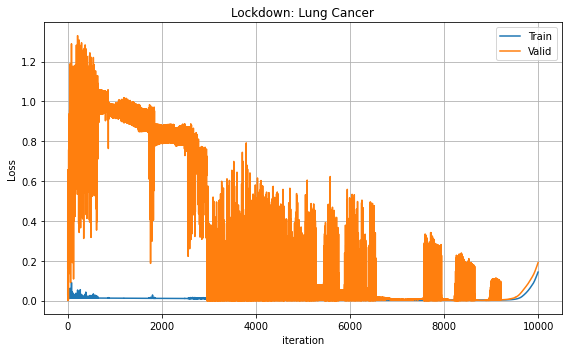

In [74]:
# Plot lockdown loss function vs iterations
train_loss = pd.read_csv('data_lockdown_10LungCarcinoma/train_loss05.csv')
valid_loss = pd.read_csv('data_lockdown_10LungCarcinoma/valid_loss05.csv')

fig, axes = plt.subplots(figsize=(8,5))

axes.plot(train_loss["iteration"].tolist(), train_loss["loss"].tolist(), label="Train")
axes.plot(valid_loss["iteration"].tolist(), valid_loss["loss"].tolist(), label="Valid")
axes.legend()
axes.set_xlabel("iteration")
axes.set_ylabel("Loss")
axes.set_title("Lockdown: Lung Cancer")
axes.grid(True, zorder=2)

plt.tight_layout()
# plt.savefig("data_lockdown_10LungCarcinoma/loss_vs_iter_forward_02.pdf", bbox_inches='tight')
plt.show()

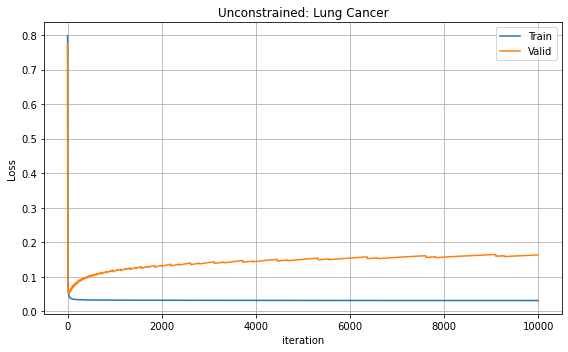

In [75]:
# Plot unconstrained loss function vs iterations
train_loss = pd.read_csv('data_lockdown_10LungCarcinoma/train_loss_fward05.csv')
valid_loss = pd.read_csv('data_lockdown_10LungCarcinoma/valid_loss_fward05.csv')

fig, axes = plt.subplots(figsize=(8,5))

axes.plot(train_loss["iteration"].tolist(), train_loss["loss"].tolist(), label="Train")
axes.plot(valid_loss["iteration"].tolist(), valid_loss["loss"].tolist(), label="Valid")
axes.legend()
axes.set_xlabel("iteration")
axes.set_ylabel("Loss")
axes.set_title("Unconstrained: Lung Cancer")
axes.grid(True, zorder=2)
# axes.set_xlim(0,100)

plt.tight_layout()
# plt.savefig("data_unconstrained_10LungCarcinoma/loss_vs_iter_forward_02.pdf", bbox_inches='tight')
plt.show()

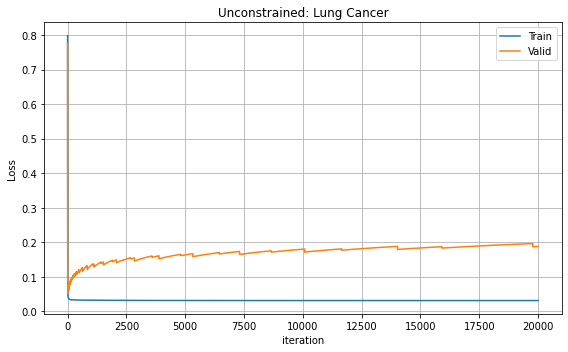

In [42]:
# Plot unconstrained loss function vs iterations
train_loss = pd.read_csv('data_unconstrained_10LungCarcinoma/train_loss05.csv')
valid_loss = pd.read_csv('data_unconstrained_10LungCarcinoma/valid_loss05.csv')

fig, axes = plt.subplots(figsize=(8,5))

axes.plot(train_loss["iteration"].tolist(), train_loss["loss"].tolist(), label="Train")
axes.plot(valid_loss["iteration"].tolist(), valid_loss["loss"].tolist(), label="Valid")
axes.legend()
axes.set_xlabel("iteration")
axes.set_ylabel("Loss")
axes.set_title("Unconstrained: Lung Cancer")
axes.grid(True, zorder=2)
# axes.set_xlim(0,100)

plt.tight_layout()
# plt.savefig("data_unconstrained_10LungCarcinoma/loss_vs_iter_forward_02.pdf", bbox_inches='tight')
plt.show()

* ### Comparison

In [2]:
# Read distributions
accuracy_lockdown = pd.read_csv('data_lockdown_10LungCarcinoma/accuracy10_backward05.csv', index_col=0)
accuracy_forward  = pd.read_csv('data_unconstrained_10LungCarcinoma/accuracy10_forward05.csv', index_col=0)
accuracy_xgb      = pd.read_csv('data_xgb_10LungCarcinoma/accuracy10_xgb_val.csv')
accuracy_lasso    = pd.read_csv('data_lasso_10LungCarcinoma/accuracy10_lasso_val.csv')

In [232]:
# Accuracy & Loss
print("Accuracy on 'test' set:")
print("Lockdown = {:.4f} +/- {:.3f}".format(accuracy_lockdown['test_acc'].mean(), 
                                            accuracy_lockdown['test_acc'].std()))
print("Forward  = {:.4f} +/- {:.3f}".format(accuracy_forward['test_acc'].mean(), 
                                            accuracy_forward['test_acc'].std()))
print("xgboost  = {:.4f} +/- {:.3f}".format(accuracy_xgb['test_acc'].mean(), 
                                            accuracy_xgb['test_acc'].std()))
print("Lasso    = {:.4f} +/- {:.3f}".format(accuracy_lasso['test_acc'].mean(), 
                                            accuracy_lasso['test_acc'].std()))

print("\nAccuracy on 'validation' set:")
print("Lockdown = {:.4f} +/- {:.3f}".format(accuracy_lockdown['valid_acc'].mean(), 
                                            accuracy_lockdown['valid_acc'].std()))
print("Forward  = {:.4f} +/- {:.3f}".format(accuracy_forward['valid_acc'].mean(), 
                                            accuracy_forward['valid_acc'].std()))
print("xgboost  = {:.4f} +/- {:.3f}".format(accuracy_xgb['valid_acc'].mean(), 
                                            accuracy_xgb['valid_acc'].std()))
print("Lasso    = {:.4f} +/- {:.3f}".format(accuracy_lasso['valid_acc'].mean(), 
                                            accuracy_lasso['valid_acc'].std()))

Accuracy on 'test' set:
Lockdown = 0.9458 +/- 0.042
Forward  = 0.8317 +/- 0.188
xgboost  = 0.9283 +/- 0.057
Lasso    = 0.9500 +/- 0.041

Accuracy on 'validation' set:
Lockdown = 0.9571 +/- 0.043
Forward  = 0.8550 +/- 0.184
xgboost  = 0.9300 +/- 0.060
Lasso    = 0.9517 +/- 0.041


In [187]:
# Print out test results
print("On 'test' set:")
statistic, pvalue = stats.ttest_rel(accuracy_lockdown['test_acc'], accuracy_forward['test_acc'])
print("Lockdown vs Forward: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown['test_acc'], accuracy_xgb['test_acc'])
print("Lockdown vs xgboost: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown['test_acc'], accuracy_lasso['test_acc'])
print("Lockdown vs lasso:   pvalue={:e}, statistic={:e}".format(pvalue, statistic))

# 
print("\nOn 'validation' set:")
statistic, pvalue = stats.ttest_rel(accuracy_lockdown['valid_acc'], accuracy_forward['valid_acc'])
print("Lockdown vs Forward: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown['valid_acc'], accuracy_xgb['valid_acc'])
print("Lockdown vs xgboost: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown['valid_acc'], accuracy_lasso['valid_acc'])
print("Lockdown vs lasso:   pvalue={:e}, statistic={:e}".format(pvalue, statistic))

On 'test' set:
Lockdown vs Forward: pvalue=5.482765e-08, statistic=5.883393e+00
Lockdown vs xgboost: pvalue=3.283717e-03, statistic=3.013072e+00
Lockdown vs lasso:   pvalue=1.905809e-01, statistic=-1.317893e+00

On 'validation' set:
Lockdown vs Forward: pvalue=8.718655e-09, statistic=6.288402e+00
Lockdown vs xgboost: pvalue=6.951425e-07, statistic=5.302766e+00
Lockdown vs lasso:   pvalue=4.172560e-02, statistic=2.063048e+00


In [3]:
# Relative Root Mean Squared Error
rrmse_lasso = 1.0 - accuracy_lasso['test_acc']
print("Lasso   = {:.3f} +/- {:.3f}".format(rrmse_lasso.mean(), rrmse_lasso.std()))

rrmse_GB = 1.0 - accuracy_xgb['test_acc']
print("GB      = {:.3f} +/- {:.3f}".format(rrmse_GB.mean(), rrmse_GB.std()))

rrmse_fcnn = 1.0 - accuracy_forward['test_acc']
print("FCNN    = {:.3f} +/- {:.3f}".format(rrmse_fcnn.mean(), rrmse_fcnn.std()))

rrmse_lockout = 1.0 - accuracy_lockdown['test_acc']
print("Lockout = {:.3f} +/- {:.3f}".format(rrmse_lockout.mean(), rrmse_lockout.std()))

# Print out test results
print("\nOn 'test' set:")
statistic, pvalue = stats.ttest_rel(rrmse_lockout, rrmse_fcnn)
print("Lockdown vs Forward: pvalue={:.2e}, statistic={:.2e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(rrmse_lockout, rrmse_GB)
print("Lockdown vs xgboost: pvalue={:.2e}, statistic={:.2e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(rrmse_lockout, rrmse_lasso)
print("Lockdown vs lasso:   pvalue={:.2e}, statistic={:.2e}".format(pvalue, statistic))

Lasso   = 0.053 +/- 0.041
GB      = 0.072 +/- 0.057
FCNN    = 0.168 +/- 0.188
Lockout = 0.054 +/- 0.042

On 'test' set:
Lockdown vs Forward: pvalue=5.48e-08, statistic=-5.88e+00
Lockdown vs xgboost: pvalue=3.28e-03, statistic=-3.01e+00
Lockdown vs lasso:   pvalue=7.07e-01, statistic=3.76e-01
